In [7]:
import autograd.numpy as np
from autograd import grad
import scipy as sp
import scipy.optimize
from dataclasses import dataclass
from matplotlib import pyplot as plt

def dot(a, b):
    return np.multiply(a, b).sum(axis=-2)

def length(v):
    return np.linalg.norm(v, axis=-2)

def normalize(v):
    return v / np.sqrt(np.multiply(v, v).sum(axis=-2, keepdims=True))

def cross(a, b):
    return np.cross(a, b, axis=-2)

def make_vec3(x, y, z):
    return np.array((x, y, z)).reshape(3, 1)

def reflect(V, N):
    return 2 * dot(N, V) * N - V

@dataclass
class SG:
    axis: np.ndarray
    amplitude: np.ndarray
    sharpness: np.ndarray

    def eval(self, v):
        r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis) - 1))
        return r.sum(axis=0)

@dataclass
class ASG:
    x: np.ndarray
    y: np.ndarray
    z: np.ndarray
    a: np.ndarray
    l: np.ndarray
    u: np.ndarray

    def eval(self, v):
        r = self.a * np.clip(dot(self.z, v), a_min=0, a_max=None) * np.exp(-(self.l * dot(self.x, v) ** 2 + self.u * dot(self.y, v) ** 2))
        return r.sum(axis=0)

def make_D_ASG(alpha, N, V):
    alpha2 = alpha ** 2
    z = reflect(V, N).reshape(1, 3, 1)
    y = normalize(cross(N, V)).reshape(1, 3, 1)
    x = cross(y, z)
    a = 1 / (np.pi * alpha2)
    l = 2 / alpha2
    return ASG(x, y, z, a, l / 8, l / (8 * dot(N, V) ** 2))

def loss(y, Y):
    d = (y - Y) / np.max(Y)
    return np.sum(d ** 2)

def fit_f(f0, X, Y, p0, lo=None, hi=None, ni=100):
    f = lambda params: f0(X, params)

    M = np.max(Y)
    def loss(params):
        y = f(params)
        d = (y - Y) / M
        return np.sum(d ** 2)
    jac = grad(loss)
    bounds = np.stack((lo, hi)).transpose()
    if ni == 1:
        return sp.optimize.minimize(loss, p0, jac=jac, bounds=bounds)
    kwargs = {
        'jac': grad(loss),
        'bounds': bounds,
    }
    return sp.optimize.basinhopping(loss, p0, niter=ni, interval=ni//2, minimizer_kwargs=kwargs)

def adam(f, X, Y, p0, lo=None, hi=None, ni=10000):
    M = np.max(Y)
    def loss(params):
        y = f(X, params)
        d = (y - Y) / M
        return np.sum(d ** 2)
    jac = grad(loss)
    
    p = p0
    m = np.zeros_like(p)
    v = np.zeros_like(p)

    learning_rate=0.1
    beta1=0.9
    beta2=0.999
    eps=1e-8

    for i in range(ni):
        g = jac(p)
        m = (1 - beta1) * g + beta1 * m  # first  moment estimate.
        v = (1 - beta2) * (g**2) + beta2 * v  # second moment estimate.
        mhat = m / (1 - beta1**(i + 1))  # bias correction.
        vhat = v / (1 - beta2**(i + 1))
        p = p - learning_rate * mhat / (np.sqrt(vhat) + eps)
    i += 1

    return scipy.optimize.OptimizeResult(message="Success", x=p, fun=loss(p), jac=g, nit=i, nfev=i, success=True)

def polar_to_r3(phi, axis=0):
    phi = phi if len(np.shape(phi)) > 0 else np.reshape(phi, 1)
    p = np.stack((np.cos(phi), np.zeros(np.shape(phi)), np.sin(phi)), axis=axis)
    return p

def spherical_to_r3(phi, theta, axis=0):
    z = np.cos(theta)
    r = np.sqrt(1 - z * z)
    return np.stack((np.cos(phi) * r, np.sin(phi) * r, z), axis=axis)

def newton(f, x0, n):
    d_f = grad(f)
    xp = x0
    x = x0
    for i in range(n):
        x = xp - f(xp) / d_f(xp)
        xp = x
    return x

def F_schlick(f0, NoL):
    return f0 + (1 - f0) * (1 - NoL) ** 5

def G_smith(alpha, NoV, NoL):
    alpha2 = alpha ** 2;
    NoV2 = NoV ** 2
    NoL2 = NoL ** 2
    A_V = np.sqrt(1 + alpha2 * (1 - NoV2) / NoV2)
    A_L = np.sqrt(1 + alpha2 * (1 - NoL2) / NoL2)
    return 2 / (A_V + A_L)

def G1_smith(alpha, NoV):
    alpha2 = alpha ** 2;
    NoV2 = NoV ** 2
    A_V = (np.sqrt(1 + alpha2 * (1 - NoV2) / NoV2) - 1) / 2
    return 1 / (1 + A_V)

def D_ggx(alpha, NoH):
    alpha2 = alpha ** 2
    return alpha2 / (np.pi * (1 + NoH ** 2 * (alpha2 - 1)) ** 2)

def BRDF(f0, alpha, N, V, L, mul_F=True, mul_G=True, mul_D=True, mul_NoL=False):
    H = L + V
    H = H / np.linalg.norm(H, axis=0)
    HoV = dot(V, H)
    NoV = dot(N, V)
    NoL = dot(N, L)
    NoH = dot(N, H)
    F = F_schlick(f0, HoV)
    G = G_smith(alpha, NoV, NoL)
    D = D_ggx(alpha, NoH)
    f = 1 / (4 * NoV)
    if mul_F:
        f = f * F
    if mul_G:
        f = f * G
    if mul_D:
        f = f * D
    if not mul_NoL:
        f = f / NoL
    return np.where(NoL > 0, f, 0)

def r2_seq(n, seed=0.5):
    g = 1.32471795724474602596
    a1 = 1 / g
    a2 = a1 ** 2
    x, _ = np.modf(seed + a1 * n) 
    y, _ = np.modf(seed + a2 * n)
    return np.stack((x, y))

def r3_seq(n, seed=0.5):
    g = 1.22074408460575947536
    a1 = 1 / g
    a2 = a1 ** 2
    a3 = a1 ** 3
    x, _ = np.modf(seed + a1 * n) 
    y, _ = np.modf(seed + a2 * n)
    z, _ = np.modf(seed + a3 * n)
    return np.stack((x, y, z))

def uniform_sample_hemisphere(Xi):
    phi = 2 * np.pi * Xi[0]
    z = Xi[1]
    theta = np.acos(z)
    return (phi, theta)

def uniform_sample_sphere(Xi):
    phi = 2 * np.pi * Xi[0]
    z = 2 * Xi[1] - 1
    theta = np.acos(z)
    return (phi, theta)
        

In [ ]:
# Approximate maximum lambda value from epsilon support and cubemap texel size.

Res = 512
S = (2 / Res) ** 2
print(f"Texel area: {S}")
d = make_vec3(1, 1, 1)
d2 = 3
S = S / np.sqrt(d2)
print(f"Projected texel area: {S}")
r2 = S / np.pi
eps = 0.01
cos_theta = 1 - 0.5 * r2 / d2
print("Support angle: {}".format(np.degrees(np.acos(cos_theta))))
L_MAX = np.log(eps) / (cos_theta - 1)
print(f"Max lambda: {L_MAX}")

In [ ]:
# Fit visibility SG

@dataclass
class Cone:
    axis: np.ndarray
    aperture: np.ndarray

    def eval(self, v):
        return np.where(dot(v, self.axis) > np.cos(self.aperture), 1.0, 0.0)

def ka_from_lambda(l):
    return 2.0 * (l + np.exp(-l) - 1.0) / (l * l)

def l0_from_ka(ka):
    return 2.0 / (ka + 0.01) * (1.0 - ka) + 3.0 * (1.0 - ka) * ka

for ka in (0.1, 0.5, 0.9):
    N = make_vec3(0, 0, 1)
    
    l0 = l0_from_ka(ka)
    l1 = newton(lambda l: ka_from_lambda(l) - ka, l0, 1)
    sg = SG(np.reshape(N, (1, 3, 1)), np.reshape(1, (1, 1)), np.reshape(l1, (1, 1)))

    aperture = np.acos(np.sqrt(1.0 - ka))
    c = Cone(N, aperture)

    phi = np.linspace(0, np.pi, num=100)
    axis = polar_to_r3(phi)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    plt.title(f"Visibility fit for ka={ka}")
    ax.plot(phi, c.eval(axis), label=f"Cone")
    ax.plot(phi, sg.eval(axis), label=f"SG")
    ax.plot(phi, c.eval(axis) * np.sin(phi), label = f"Cosine-weighted cone")
    ax.plot(phi, sg.eval(axis) * np.sin(phi), label = f"Cosine-weighted SG")
    ax.set_rmax(1)
    ax.set_rticks([0.0, 0.5, 1])
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"Visibility fit for ka={ka}")
    ax.plot(phi - np.pi / 2.0, c.eval(axis), label=f"Cone")
    ax.plot(phi - np.pi / 2.0, sg.eval(axis), label=f"SG")
    ax.plot(phi - np.pi / 2.0, c.eval(axis) * np.sin(phi), label = f"Cosine-weighted cone")
    ax.plot(phi - np.pi / 2.0, sg.eval(axis) * np.sin(phi), label = f"Cosine-weighted SG")
    ax.set_ylim(1)
    ax.set_yticks([0.0, 0.5, 1])
    ax.grid(True)
    ax.legend()
    plt.show()

In [ ]:
# Fit normal distribution SG

for roughness in (0.1, 0.3, 0.5, 0.7, 0.9):
    N = make_vec3(0, 0, 1)
    
    alpha = roughness ** 2
    alpha2 = alpha ** 2

    phi = np.linspace(0, np.pi, num=100)
    H = polar_to_r3(phi)
    d = D_ggx(alpha, dot(N, H))

    def f(X, *args):
        args = np.array(args).reshape(-1, 2, 1)
        u = N.reshape(1, 3, 1)
        a = args[:, 0]
        l = args[:, 1]
        return SG(u, a, l).eval(X)

    sgs = []

    def fit(p0):
        k = len(p0) // 2
        lo = np.tile((-np.inf, 0), k)
        hi = np.tile(( np.inf, L_MAX), k)
        return fit_f(f, H, d, p0, lo, hi)

    popt = []
    loss = np.inf
    for k in range(1, 3):
        i = np.argmax(np.abs(d - f(H, popt)))
        popt = np.append(popt, (0, 0))
        res = fit(popt)
        popt = res.x
        print(f"Fit {k} SG(s) in {res.nit} iteration(s): {res.message}")
        print(f"Optimal parameters:\n{popt.reshape(-1, 2)}")
        print(f"Loss: {res.fun} ({loss / res.fun}x better)")
        loss = res.fun
        sgs.append(popt)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    plt.title(f"D fit for Roughness={roughness}")
    ax.plot(phi, d, label="GGX")
    for i, sg in enumerate(sgs):
        k = i + 1
        print(sg)
        ax.plot(phi, f(H, sg), label=f"{k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"D fit for Roughness={roughness}")
    ax.plot(phi - np.pi / 2.0, d, label="GGX")
    for i, sg in enumerate(sgs):
        k = i + 1
        ax.plot(phi - np.pi / 2.0, f(H, sg), label=f"{k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

In [ ]:
# Fit BRDF SG

for mul_NoL in (False, True):
    for roughness in (0.1, 0.3, 0.5, 0.7, 0.9):
        f0 = 0.04
        alpha = roughness ** 2
        alpha2 = alpha ** 2
    
        N_phi = np.pi / 2
        V_phi = 3 * np.pi / 4
        R_phi = 2 * N_phi - V_phi
        N = polar_to_r3(N_phi)
        V = polar_to_r3(V_phi)

        if mul_NoL:
            phi = np.linspace(-np.pi / 2, 3 * np.pi / 2, num=100)
        else:
            phi = np.linspace(0, np.pi, num=100)
        L = polar_to_r3(phi)
        y = BRDF(f0, alpha, N, V, L, mul_NoL=mul_NoL)
    
        def f(X, params):
            params = params.reshape(-1, 3, 1)
            u = polar_to_r3(params[:, 0], axis=1)
            a = params[:, 1]
            l = params[:, 2]
            return SG(u, a, l).eval(X)
    
        MIN_SG = 2
        MAX_SG = 4
        sgs = []
    
        def fit(p0):
            k = len(p0) // 3
            lo = np.tile((-np.pi, -np.inf, 0), k)
            hi = np.tile(( np.pi,  np.inf, L_MAX), k)
            return fit_f(f, L, y, p0, lo, hi)
    
        res = fit(np.array([R_phi, 1 / (np.pi * alpha2), 2 / alpha2]))
        popt = res.x
        loss = res.fun
        for k in range(MIN_SG, MAX_SG + 1):
            i = np.argmax(np.abs(y - f(L, popt)))
            popt = np.append(popt, (phi[i], 0, 0))
            res = fit(popt)
            popt = res.x
            print(f"Fit {k} SG(s) in {res.nit} iteration(s): {res.message}")
            print(f"Optimal parameters:\n{popt.reshape(-1, 3)}")
            print(f"Loss: {res.fun} ({loss / res.fun}x better)")
            loss = res.fun
            sgs.append(popt)

        if mul_NoL:
            brdf_str = "BRDF * (N, L)"
            f_str = "f * (N, L)"
        else:
            brdf_str = "BRDF"
            f_str = "f"
    
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        plt.title(f"{brdf_str} fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
        ax.plot(phi, y, label=f_str)
        for k, sg in enumerate(sgs, start=MIN_SG):
            ax.plot(phi, f(L, sg), label=f"{f_str}: {k} SG(s)")
        ax.grid(True)
        ax.legend()
        plt.show()
    
        fig, ax = plt.subplots()
        plt.title(f"{brdf_str} fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
        ax.plot(-phi + np.pi / 2, y, label=f_str)
        for k, sg in enumerate(sgs, start=MIN_SG):
            ax.plot(-phi + np.pi / 2, f(L, sg), label=f"{f_str}: {k} SG(s)")
        ax.grid(True)
        ax.legend()
        plt.show()

In [ ]:
# Fit BRDF SG in 3D

for mul_NoL in (False, True):
    for roughness in (0.1, 0.3, 0.5, 0.7, 0.9):
        f0 = 0.04
        alpha = roughness ** 2
    
        N_phi = np.pi / 2
        V_phi = 3 * np.pi / 4
        R_phi = 2 * N_phi - V_phi
        N = polar_to_r3(N_phi)
        V = polar_to_r3(V_phi)
        R = polar_to_r3(R_phi)
    
        Xi = r2_seq(np.arange(10000))
        if mul_NoL:
            (phi, theta) = uniform_sample_sphere(Xi)
        else:
            (phi, theta) = uniform_sample_hemisphere(Xi)
        L = spherical_to_r3(phi, theta)
        y = BRDF(f0, alpha, N, V, L, mul_NoL=mul_NoL)
        
        def f(X, params):
            params = params.reshape(-1, 4, 1)
            phi = params[:, 0]
            theta = params[:, 1]
            u = spherical_to_r3(phi, theta, axis=1)
            a = params[:, 2]
            l = params[:, 3]
            return SG(u, a, l).eval(X)
    
        MIN_SG = 2
        MAX_SG = 4
        sgs = []
    
        def fit(p0):
            k = len(p0) // 4
            lo = np.tile((-2 * np.pi, -np.pi, -np.inf, 0    ), k)
            hi = np.tile(( 2 * np.pi,  np.pi,  np.inf, L_MAX), k)
            return fit_f(f, L, y, p0, lo, hi, ni=100)
    
        res = fit(np.array((np.arctan2(R[1], R[0])[0], np.acos(R[2])[0], 1 / (np.pi * alpha2), 2 / alpha2)))
        popt = res.x
        loss = res.fun
        for k in range(MIN_SG, MAX_SG + 1):
            i = np.argmax(np.abs(y - f(L, popt)))
            popt = np.append(popt, (phi[i], theta[i], 0, 0))
            res = fit(popt)
            popt = res.x
            print(f"Fit {k} SG(s) in {res.nit} iteration(s): {res.message}")
            print(f"Optimal parameters:\n{popt.reshape(-1, 4)}")
            print(f"Loss: {res.fun} ({loss / res.fun}x better)")
            loss = res.fun
            sgs.append(popt)

        if mul_NoL:
            phi = np.linspace(-np.pi / 2, 3 * np.pi / 2, num=100)
            brdf_str = "BRDF (N, L)"
            f_str = "f (N, L)"
        else:
            phi = np.linspace(0, np.pi, num=100)
            brdf_str = "BRDF"
            f_str = "f"

        L = polar_to_r3(phi)
        y = BRDF(f0, alpha, N, V, L, mul_NoL=mul_NoL)
    
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        plt.title(f"{brdf_str} fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
        ax.plot(phi, y, label=f_str)
        for k, sg in enumerate(sgs, start=MIN_SG):
            ax.plot(phi, f(L, sg), label=f"{f_str}: {k} SG(s)")
        ax.grid(True)
        ax.legend()
        plt.show()
    
        fig, ax = plt.subplots()
        plt.title(f"{brdf_str} fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
        ax.plot(-phi + np.pi / 2, y, label=f_str)
        for k, sg in enumerate(sgs, start=MIN_SG):
            ax.plot(-phi + np.pi / 2, f(L, sg), label=f"{f_str}: {k} SG(s)")
        ax.grid(True)
        ax.legend()
        plt.show()
    
        W = 30
        H = 30
        
        Xix = np.linspace(0, 1, num=W)
        Xiy = np.linspace(0, 1, num=H)
        Xix, Xiy = np.meshgrid(Xix, Xiy)
        Xix = Xix.flatten()
        Xiy = Xiy.flatten()
        X = np.stack(uniform_sample_hemisphere((Xix, Xiy)))
        L = spherical_to_r3(*X)
        y = BRDF(f0, alpha, N, V, L, mul_NoL=mul_NoL).reshape(H, W)
        P = L.reshape(3, H, W) * y
    
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        plt.title(f"{brdf_str} fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
        ax.plot_surface(P[0], P[1], P[2], antialiased=False, label=f_str)
        for k, sg in enumerate(sgs, start=MIN_SG):
            y = f(L, sg).reshape(H, W)
            P = L.reshape(3, H, W) * y
            try:
                ax.plot_surface(P[0], P[1], P[2], antialiased=False, label=f"{f_str}: {k} SG(s)")
            except ValueError:
                continue
        ax.legend()
        plt.show()

In [ ]:
# Fit F * G * D SG

for roughness in (0.5, 0.7, 0.9, 1.0):
    for V_phi in (35, 65, 89):
        f0 = 0.04
        alpha = roughness ** 2
    
        N = polar_to_r3(np.pi / 2)
        V = polar_to_r3(np.pi / 2 + np.radians(V_phi))
        R = polar_to_r3(np.pi / 2 - np.radians(V_phi))

        phi = np.linspace(0, np.pi, num=100)
        L = polar_to_r3(phi)
        H = normalize(L + V)

        y = F_schlick(f0, dot(H, V)) * D_ggx(alpha, dot(N, H)) * G_smith(alpha, dot(N, V), dot(N, L)) * np.heaviside(dot(N, L), 0)
      
        def f(X, *args):
            args = np.array(args).reshape(-1, 3, 1)
            u = polar_to_r3(args[:, 0], axis=1)
            h = u + V
            h = h / np.linalg.norm(h, axis=-2).reshape(h.shape[0], 1, h.shape[2])
            a = args[:, 1] * F_schlick(f0, dot(h, V))
            l = args[:, 2]
            return SG(u, a, l).eval(X)
    
        sgs = []
    
        def fit(p0):
            k = len(p0) // 3
            lo = np.tile((-np.pi, -np.inf, 0), k)
            hi = np.tile(( np.pi,  np.inf, L_MAX), k)
            return fit_f(f, L, y, p0, lo, hi)
    
        popt = None
        loss = np.inf
        for k in range(1, 3 + 1):
            if popt is None:
                i = np.argmax(np.abs(y))
                popt = np.array([phi[i], 0, 0])
            else:
                i = np.argmax(np.abs(y - f(L, popt)))
                popt = np.append(popt, (phi[i], 0, 0))
            res = fit(popt)
            popt = res.x
            print(f"Fit {k} SG(s) in {res.nit} iteration(s): {res.message}")
            print(f"Optimal parameters:\n{popt.reshape(-1, 3)}")
            print(f"Loss: {res.fun} ({loss / res.fun}x better)")
            loss = res.fun
            sgs.append(popt)
    
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        plt.title(f"Roughness={roughness}, V_phi={V_phi}")
        ax.plot(phi, y, label="y")
        for sg in sgs:
            k = len(sg) // 3
            ax.plot(phi, f(L, sg), label=f"{k} SG(s)")
        ax.legend()
        ax.grid(True)
        plt.show()
    
        fig, ax = plt.subplots()
        plt.title(f"Roughness={roughness}, V_phi={V_phi}")
        ax.plot(np.pi / 2 - phi, y, label="y")
        for sg in sgs:
            k = len(sg) // 3
            ax.plot(np.pi / 2 - phi, f(L, sg), label=f"{k} SG(s)")
        ax.grid(True)
        ax.legend()
        plt.show()

In [ ]:
# Fit F * G * D ASG

for roughness in (0.5, 0.7, 0.9, 1.0):
    for V_phi in (35, 65, 89):
        f0 = 0.04
        alpha = roughness ** 2
    
        N = polar_to_r3(np.pi / 2)
        V = polar_to_r3(np.pi / 2 + np.radians(V_phi))
        R = polar_to_r3(np.pi / 2 - np.radians(V_phi))

        phi = np.linspace(-1/2*np.pi, 3/2*np.pi, num=200)
        L = polar_to_r3(phi)
        H = normalize(L + V)

        y = F_schlick(f0, dot(H, V)) * D_ggx(alpha, dot(N, H)) * G_smith(alpha, dot(N, V), dot(N, L)) * np.heaviside(dot(N, L), 0)

        NUM_PARAMS = 3
      
        def f(X, params):
            params = params.reshape(-1, NUM_PARAMS, 1)
            y = normalize(cross(N, V)).reshape(1, 3, 1)
            z = polar_to_r3(params[:, 0], axis=1)
            x = cross(y, z)
            v = V.reshape(1, 3, 1)
            a = params[:, 1] * F_schlick(f0, dot(normalize(z + v), v))
            l = params[:, 2]
            return ASG(x, y, z, a, l, 0).eval(X)
    
        asgs = []
    
        def fit(p0):
            k = len(p0) // 3
            lo = np.tile((-np.pi, 0,      0), k)
            hi = np.tile(( np.pi, np.inf, L_MAX), k)
            return fit_f(f, L, y, p0, lo, hi)
    
        popt = None
        l = np.inf
        for k in range(1, 4 + 1):
            if popt is None:
                i = np.argmax(np.abs(y))
                popt = np.array([phi[i], 0, 0])
            else:
                i = np.argmax(np.abs(y - f(L, popt)))
                popt = np.append(popt, (phi[i], 0, 0))
            res = fit(popt)
            popt = res.x
            print(f"Fit {k} SG(s) in {res.nit} iteration(s): {res.message}")
            print(f"Optimal parameters:\n{popt.reshape(-1, 3)}")
            print(f"Loss: {res.fun} ({l / res.fun}x better)")
            l = res.fun
            asgs.append(popt)
    
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        plt.title(f"Roughness={roughness}, V_phi={V_phi}")
        ax.plot(phi, y, label="y")
        for asg in asgs:
            k = len(asg) // 3
            p = f(L, asg)
            ax.plot(phi, p, label=f"{k} SG(s): {loss(p, y):.2}")
        ax.legend()
        ax.grid(True)
        plt.show()
    
        fig, ax = plt.subplots()
        plt.title(f"Roughness={roughness}, V_phi={V_phi}")
        ax.plot(np.pi / 2 - phi, y, label="y")
        for asg in asgs:
            k = len(asg) // 3
            p = f(L, asg)
            ax.plot(np.pi / 2 - phi, p, label=f"{k} SG(s): {loss(p, y):.2}")
        ax.grid(True)
        ax.legend()
        plt.show()

/tmp/ipykernel_14553/481435916.py:135: RuntimeWarning: divide by zero encountered in divide
  A_L = np.sqrt(1 + alpha2 * (1 - NoL2) / NoL2)


Initial parameters:
[[1.55334303 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.55336641 10.77953789 10.66863176 10.65245204]]
Loss: 1.460982432268255 (infx better)

Initial parameters:
[[ 1.55336641 10.77953789 10.66863176 10.65245204]
 [ 1.35055191  0.          0.          0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.55330606  9.17525311 19.61879652 19.63198417]
 [ 1.55347607  2.95989198  3.94096617  3.94125711]]
Loss: 0.039287976243283666 (37.18650263941788x better)

Initial parameters:
[[ 1.55330606  9.17525311 19.61879652 19.63198417]
 [ 1.55347607  2.95989198  3.94096617  3.94125711]
 [ 1.35055191  0.          0.          0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.55337075  5

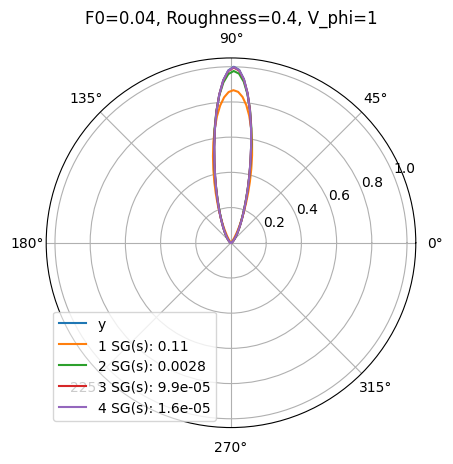

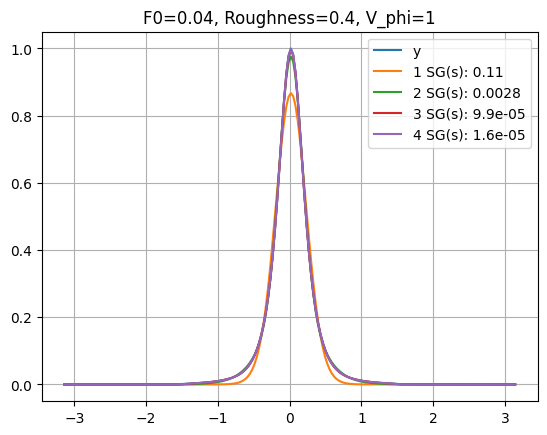

Initial parameters:
[[1.30899694 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.30933021 10.77133034 10.6642687  11.43423087]]
Loss: 1.4255228346526652 (infx better)

Initial parameters:
[[ 1.30933021 10.77133034 10.6642687  11.43423087]
 [ 0.0926962   0.          0.          0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.30893833  9.15844566 19.62934498 21.0877767 ]
 [ 1.31117707  2.96616552  3.9638031   4.24295846]]
Loss: 0.038663473081659974 (36.87001505637791x better)

Initial parameters:
[[ 1.30893833  9.15844566 19.62934498 21.0877767 ]
 [ 1.31117707  2.96616552  3.9638031   4.24295846]
 [ 0.0926962   0.          0.          0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.30956317  

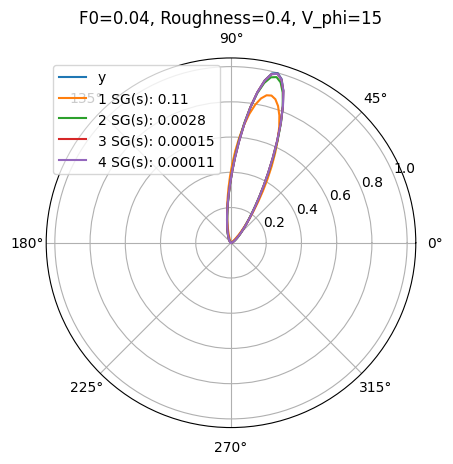

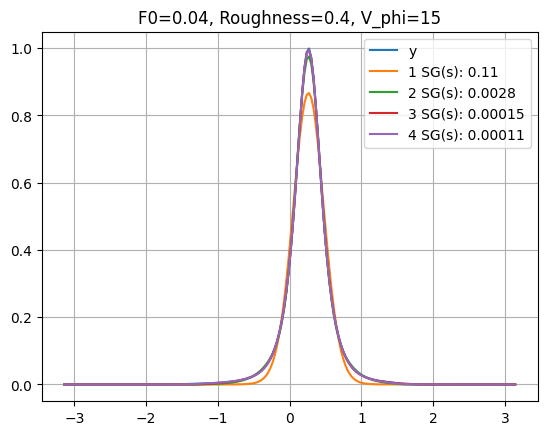

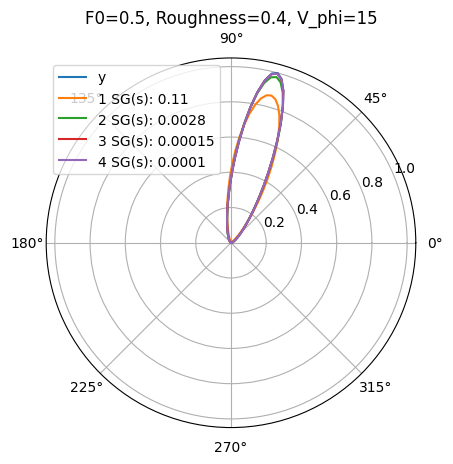

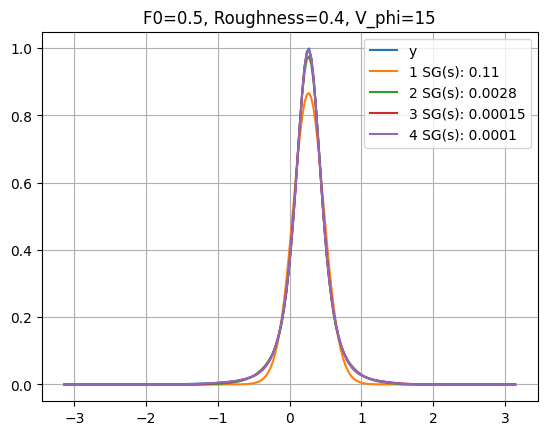

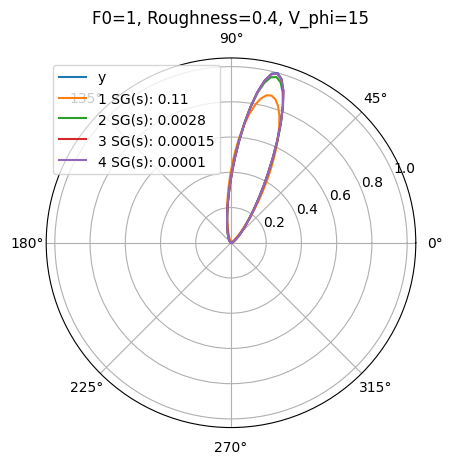

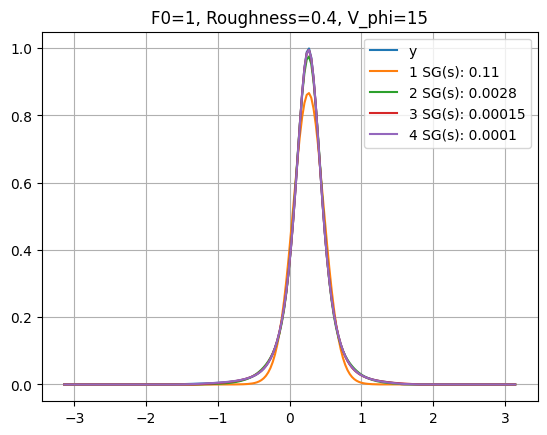

Initial parameters:
[[1.04719755 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.04864503 10.74290959 10.68711533 14.27638303]]
Loss: 1.3321008965358778 (infx better)

Initial parameters:
[[ 1.04864503 10.74290959 10.68711533 14.27638303]
 [ 6.23362517  0.          0.          0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.04645376  9.06916681 19.75262461 26.59994745]
 [ 1.05825359  3.02490695  4.10061977  5.36229982]]
Loss: 0.045415168185799576 (29.331629712039675x better)

Initial parameters:
[[ 1.04645376  9.06916681 19.75262461 26.59994745]
 [ 1.05825359  3.02490695  4.10061977  5.36229982]
 [ 6.23362517  0.          0.          0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.04816449 

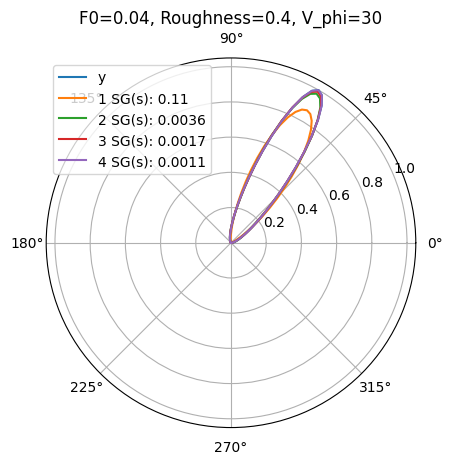

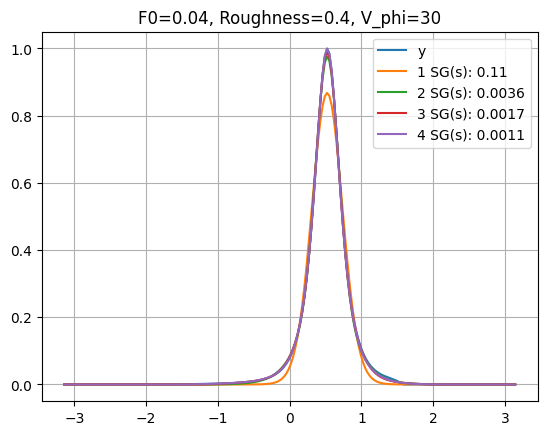

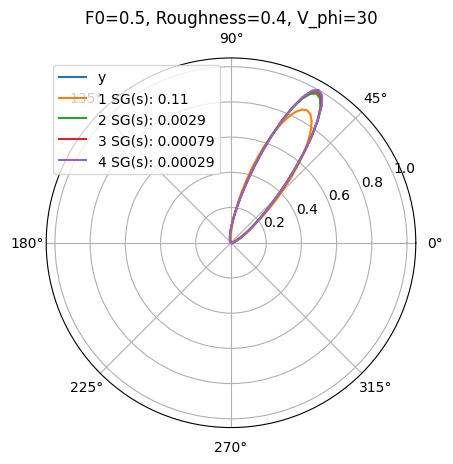

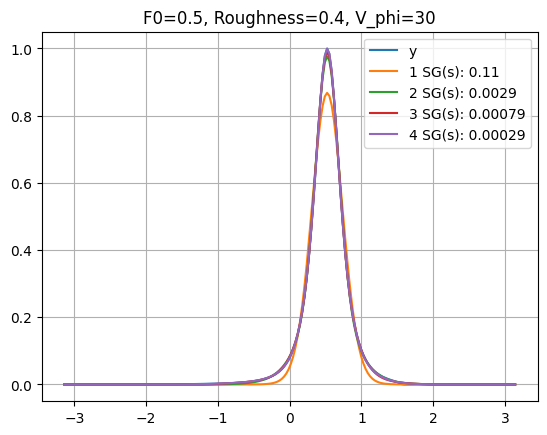

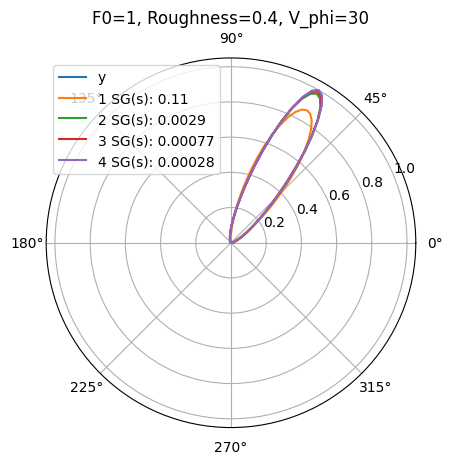

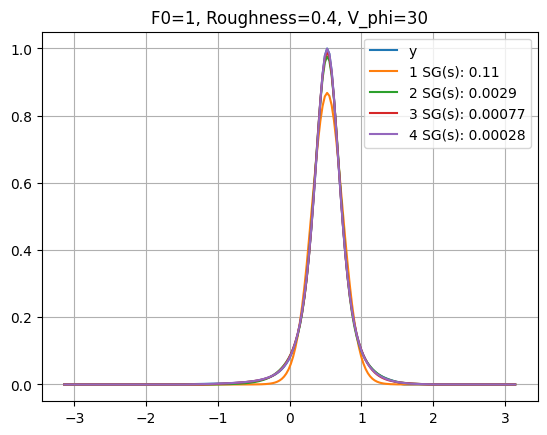

Initial parameters:
[[0.78539816 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.79035098 10.53806316 10.57184522 21.10449048]]
Loss: 1.0514711316298713 (infx better)

Initial parameters:
[[7.90350980e-01 1.05380632e+01 1.05718452e+01 2.11044905e+01]
 [4.01901689e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.78210025  8.94787948 19.26725545 40.24604376]
 [ 0.81884995  3.01194327  4.40724995  7.8538138 ]]
Loss: 0.09430858868665011 (11.149261655515716x better)

Initial parameters:
[[ 0.78210025  8.94787948 19.26725545 40.24604376]
 [ 0.81884995  3.01194327  4.40724995  7.8538138 ]
 [ 6.1905294   0.          0.          0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal par

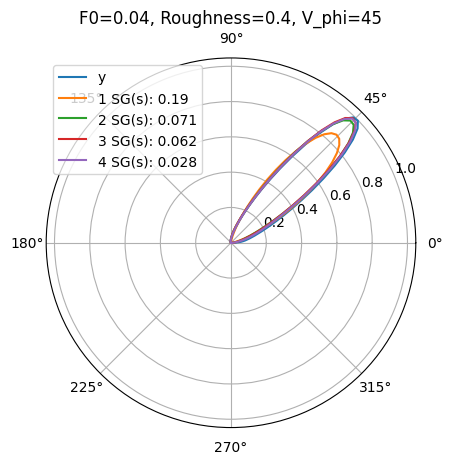

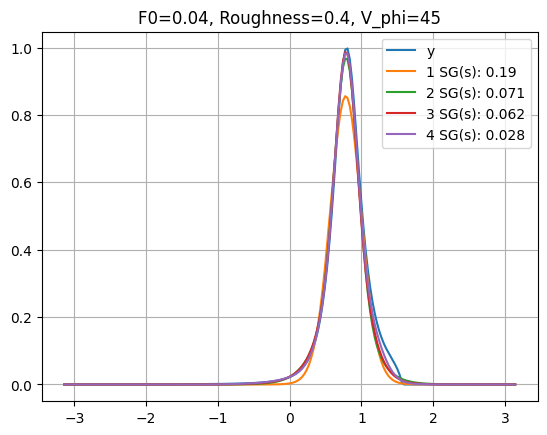

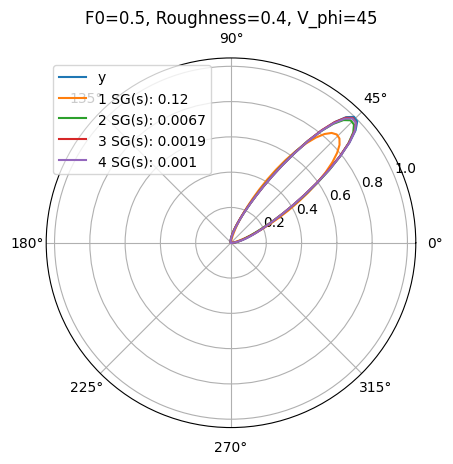

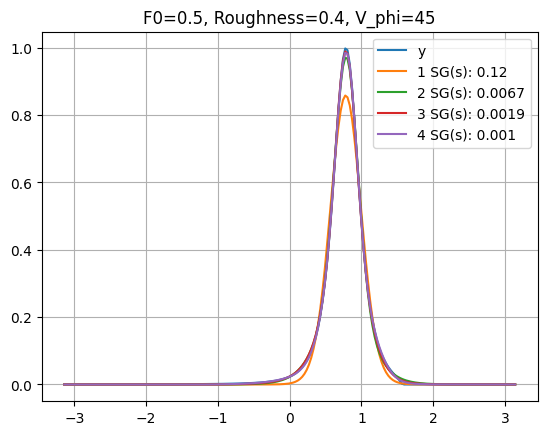

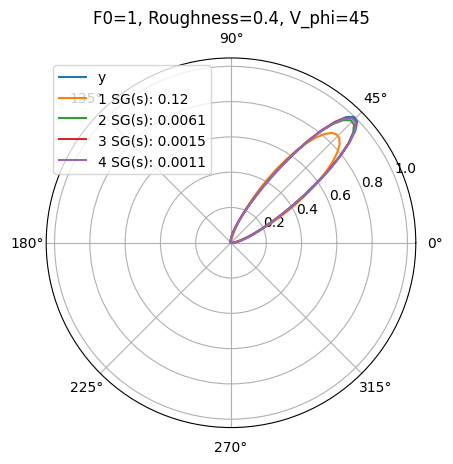

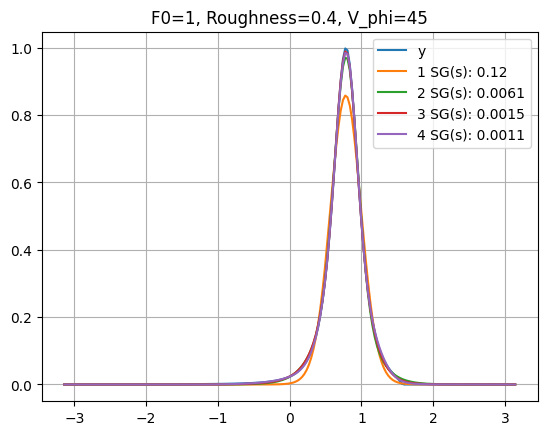

Initial parameters:
[[0.52359878 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.53329754 10.51000599 11.4656478  43.08009017]]
Loss: 1.0240217050767235 (infx better)

Initial parameters:
[[5.33297537e-01 1.05100060e+01 1.14656478e+01 4.30800902e+01]
 [5.26183575e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.50595807  9.66966906 16.15439273 68.40388269]
 [ 0.67199666  2.06014014  5.60999913 10.02338998]]
Loss: 0.2408952107932008 (4.250901052390811x better)

Initial parameters:
[[5.05958073e-01 9.66966906e+00 1.61543927e+01 6.84038827e+01]
 [6.71996658e-01 2.06014014e+00 5.60999913e+00 1.00233900e+01]
 [2.25001445e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations co

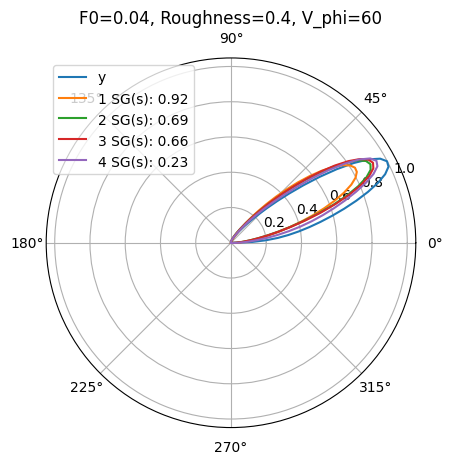

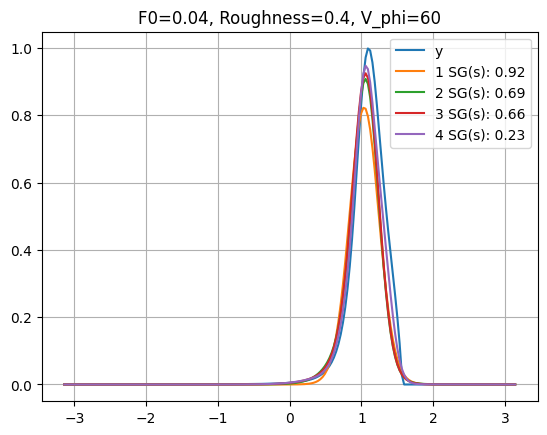

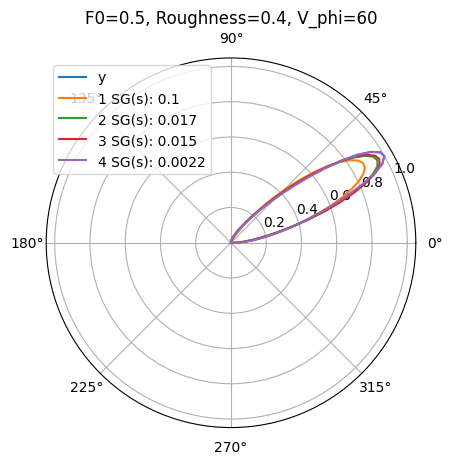

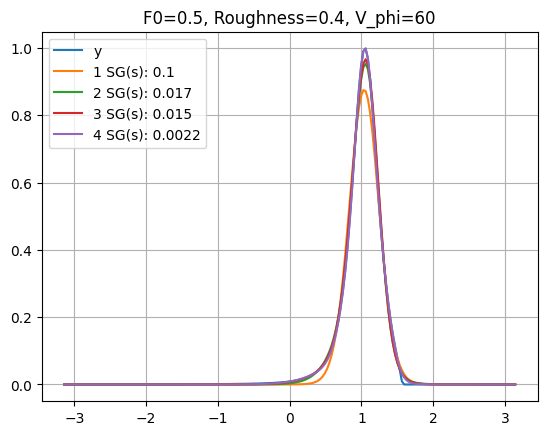

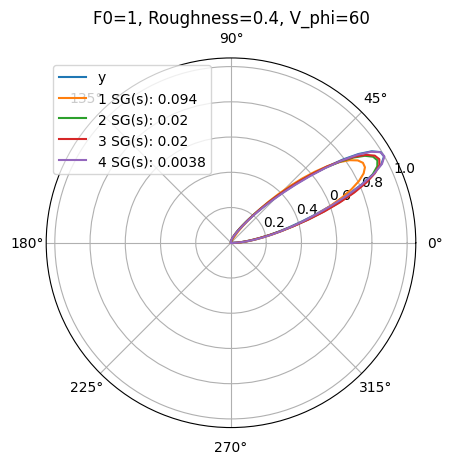

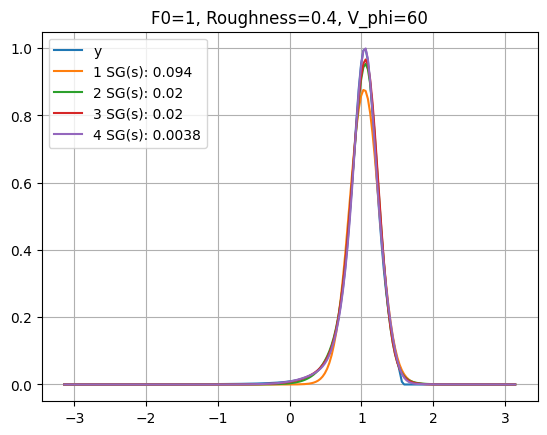

Initial parameters:
[[0.26179939 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[  0.30707118   9.74237134  17.44966878 148.95465852]]
Loss: 1.2983623758633178 (infx better)

Initial parameters:
[[  0.30707118   9.74237134  17.44966878 148.95465852]
 [  6.26934461   0.           0.           0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[2.44128804e-01 9.29760868e+00 3.42025608e+01 3.02134131e+02]
 [4.54173823e-01 3.62317122e+00 1.51124662e+01 4.28734574e+01]]
Loss: 0.3005380166256076 (4.320126919186868x better)

Initial parameters:
[[2.44128804e-01 9.29760868e+00 3.42025608e+01 3.02134131e+02]
 [4.54173823e-01 3.62317122e+00 1.51124662e+01 4.28734574e+01]
 [6.26934461e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping i

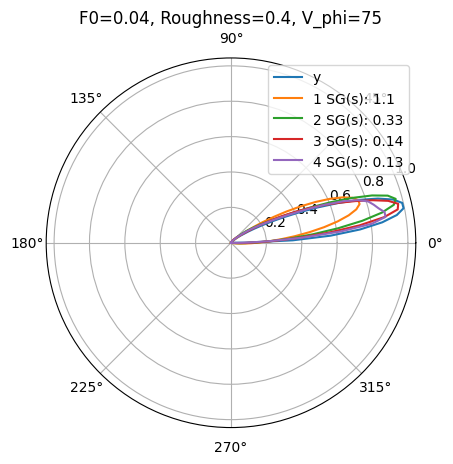

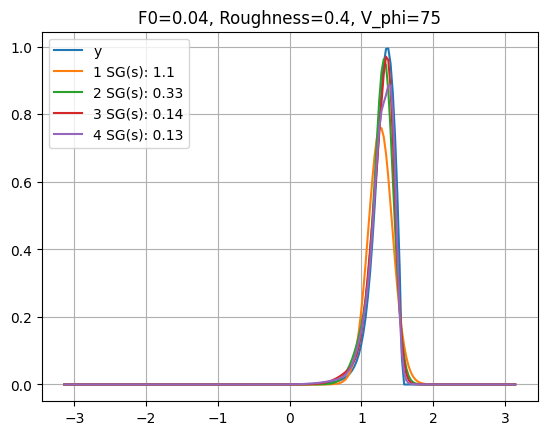

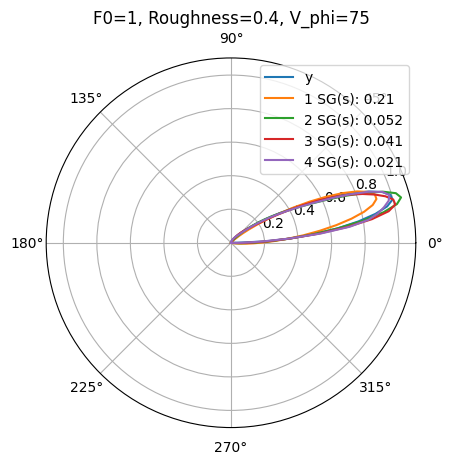

Initial parameters:
[[0.01745329 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[2.12617313e-01 1.29413229e+00 3.86506095e+01 6.95506710e+02]]
Loss: 0.9820320659714296 (infx better)

Initial parameters:
[[2.12617313e-01 1.29413229e+00 3.86506095e+01 6.95506710e+02]
 [6.27734235e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.68969385e-01 1.41922412e+00 9.11014895e+01 1.49071359e+03]
 [3.62085686e-01 4.48173174e-01 2.34419595e+01 1.28927115e+02]]
Loss: 0.24849741797163258 (3.9518803615236524x better)

Initial parameters:
[[1.68969385e-01 1.41922412e+00 9.11014895e+01 1.49071359e+03]
 [3.62085686e-01 4.48173174e-01 2.34419595e+01 1.28927115e+02]
 [6.26934461e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 3 SG(s) in 10 iteration(s): ['requeste

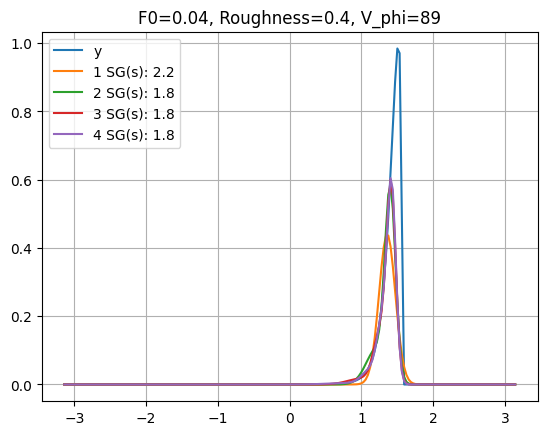

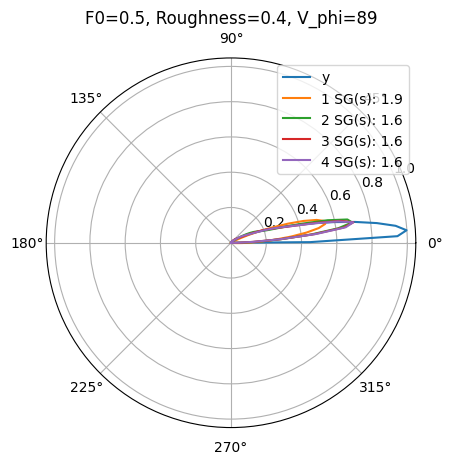

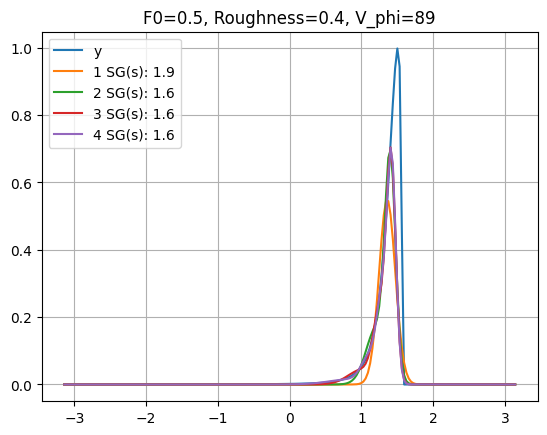

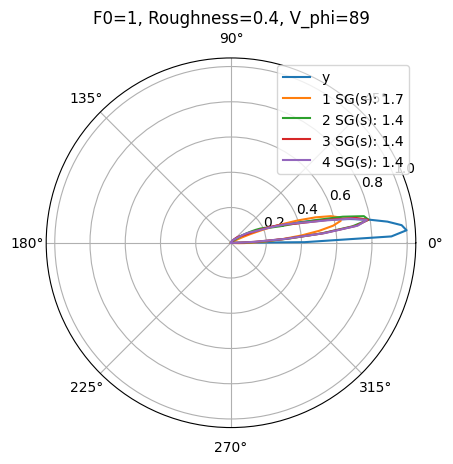

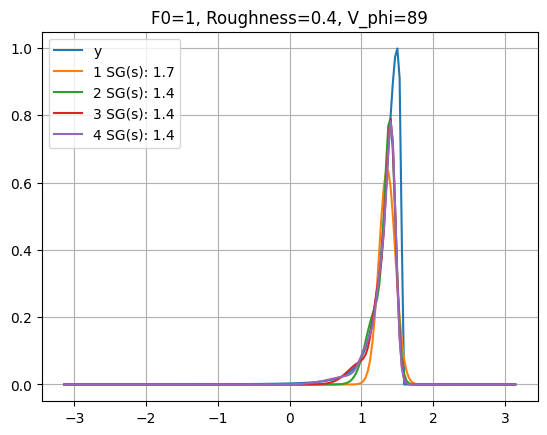

Initial parameters:
[[1.55334303 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.55352765 4.50183211 4.1901741  4.19314039]]
Loss: 2.2731252620729507 (infx better)

Initial parameters:
[[1.55352765 4.50183211 4.1901741  4.19314039]
 [1.35055191 0.         0.         0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.55310189 3.55459911 8.19729385 8.19814109]
 [1.55463642 1.46675668 1.62427372 1.62477932]]
Loss: 0.03468256998163219 (65.54085418920204x better)

Initial parameters:
[[1.55310189 3.55459911 8.19729385 8.19814109]
 [1.55463642 1.46675668 1.62427372 1.62477932]
 [1.35055191 0.         0.         0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.55390301  1.61241283 13.66833369 13.6735623

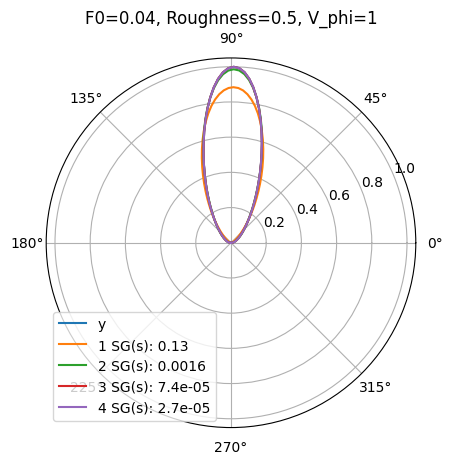

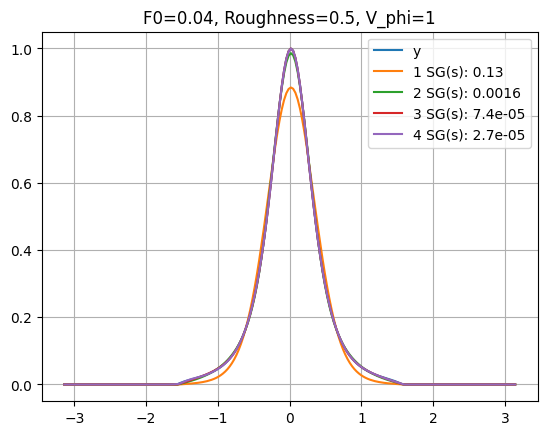

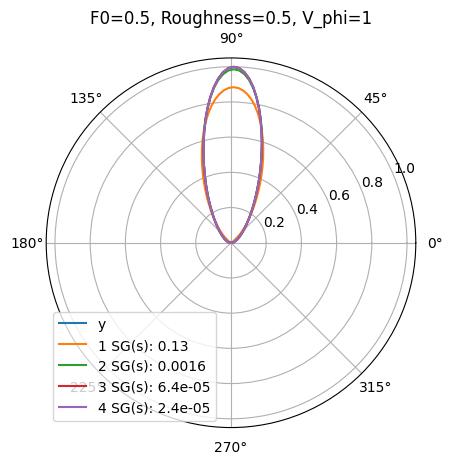

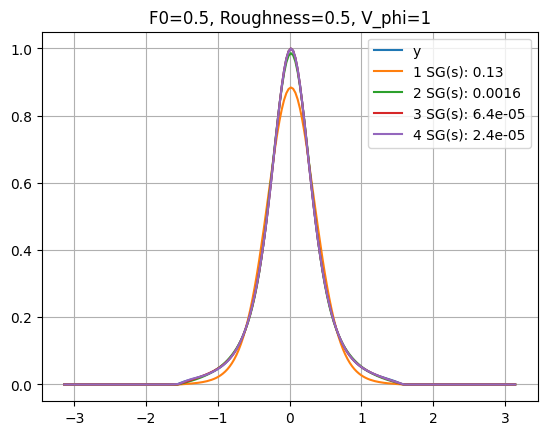

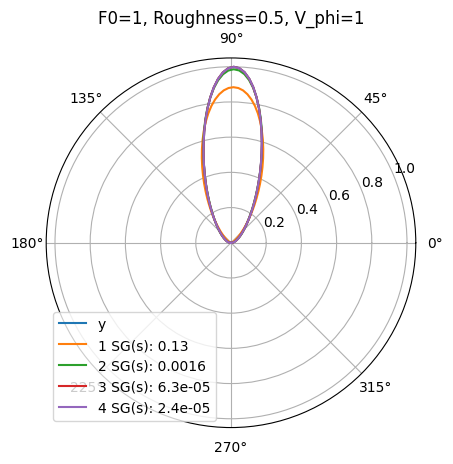

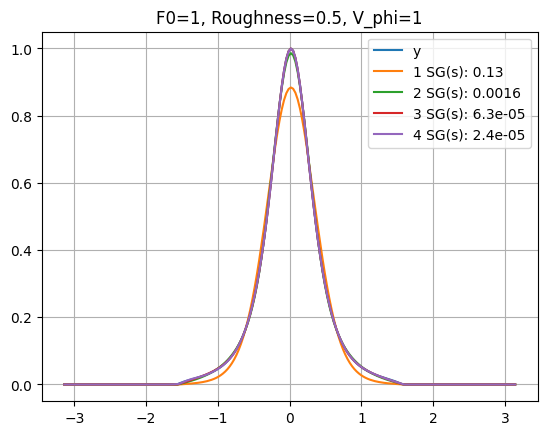

Initial parameters:
[[1.30899694 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.31126964 4.49408668 4.21710687 4.50895477]]
Loss: 2.1995458902254215 (infx better)

Initial parameters:
[[1.31126964 4.49408668 4.21710687 4.50895477]
 [0.0643531  0.         0.         0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.30509902 3.44216734 8.35764775 9.06758438]
 [1.32853092 1.57348525 1.79660645 1.88860919]]
Loss: 0.1018628983978884 (21.593199534080977x better)

Initial parameters:
[[1.30509902 3.44216734 8.35764775 9.06758438]
 [1.32853092 1.57348525 1.79660645 1.88860919]
 [6.26379221 0.         0.         0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.31467586  2.42503824 10.68113485 11.5962159

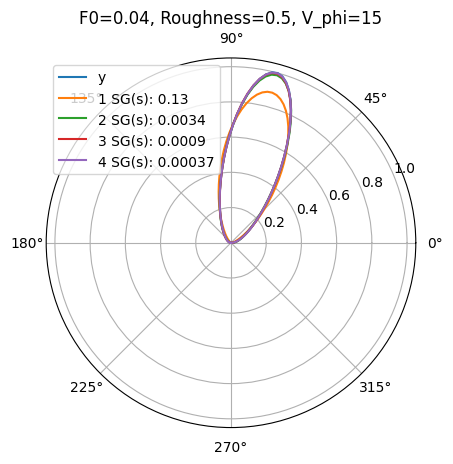

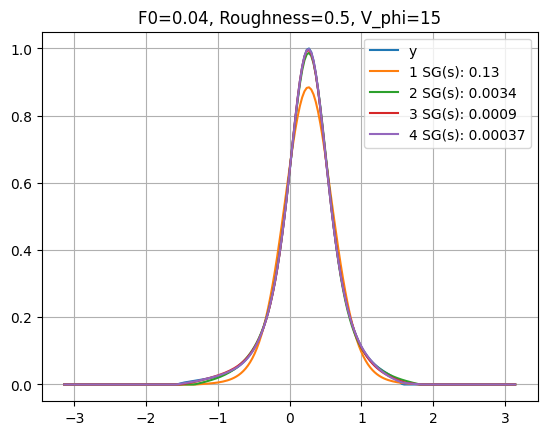

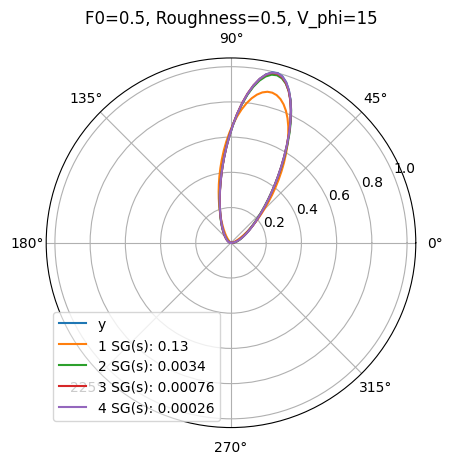

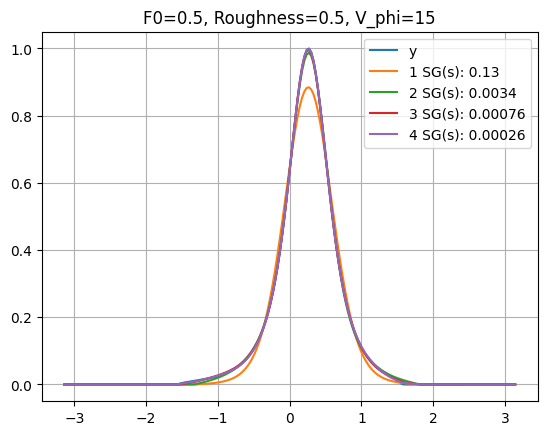

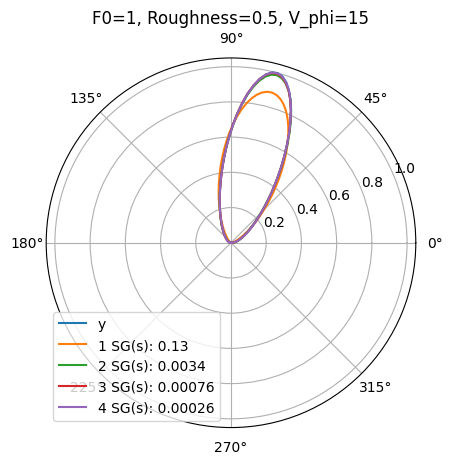

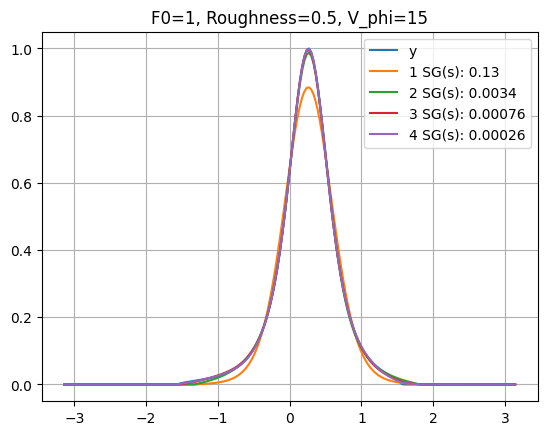

Initial parameters:
[[1.04719755 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.05585708 4.46536367 4.32292386 5.63971036]]
Loss: 2.1573376695370055 (infx better)

Initial parameters:
[[1.05585708 4.46536367 4.32292386 5.63971036]
 [0.0588007  0.         0.         0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.03532309  3.55417171  7.64062639 10.72560414]
 [ 1.11605612  1.39771677  1.90018412  2.18160128]]
Loss: 0.2714454718071411 (7.947591297709209x better)

Initial parameters:
[[ 1.03532309  3.55417171  7.64062639 10.72560414]
 [ 1.11605612  1.39771677  1.90018412  2.18160128]
 [ 0.30200125  0.          0.          0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 1.03532308  3.55417171  7.

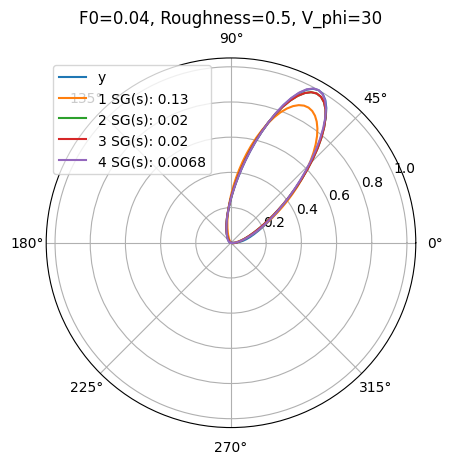

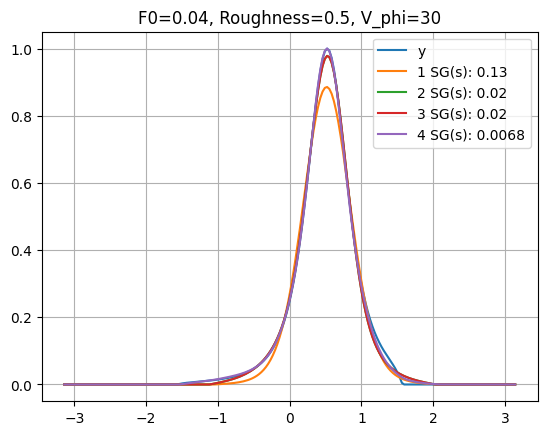

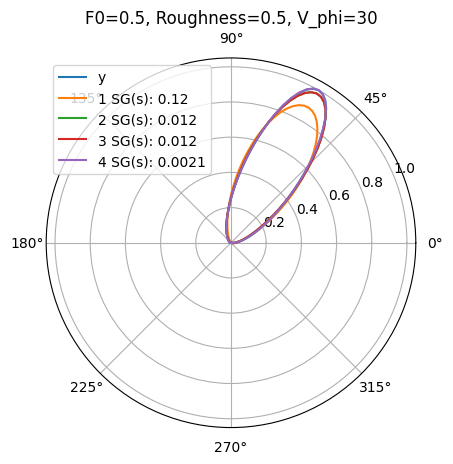

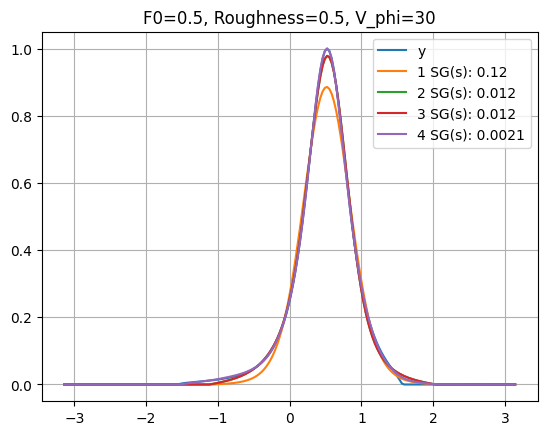

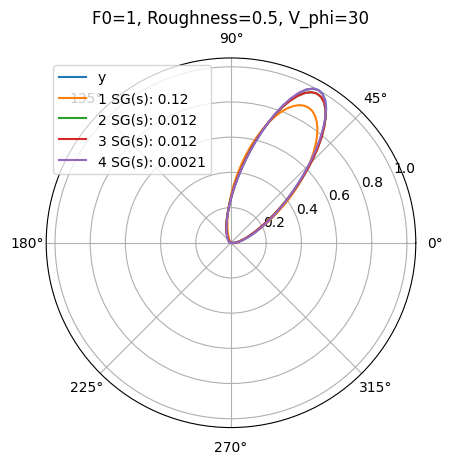

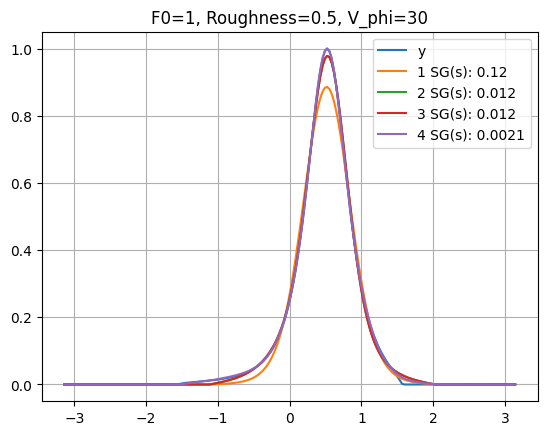

Initial parameters:
[[0.78539816 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[0.80786105 4.40992974 4.64831211 8.41790864]]
Loss: 2.4650435019878976 (infx better)

Initial parameters:
[[0.80786105 4.40992974 4.64831211 8.41790864]
 [6.27920658 0.         0.         0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.76576928  4.06507377  6.5662098  13.01919877]
 [ 1.04049357  0.82617947  2.07759996  1.9351605 ]]
Loss: 0.421041264388877 (5.854636375286875x better)

Initial parameters:
[[ 0.76576928  4.06507377  6.5662098  13.01919877]
 [ 1.04049357  0.82617947  2.07759996  1.9351605 ]
 [ 0.30200125  0.          0.          0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.76374661  4.00450185  6.6

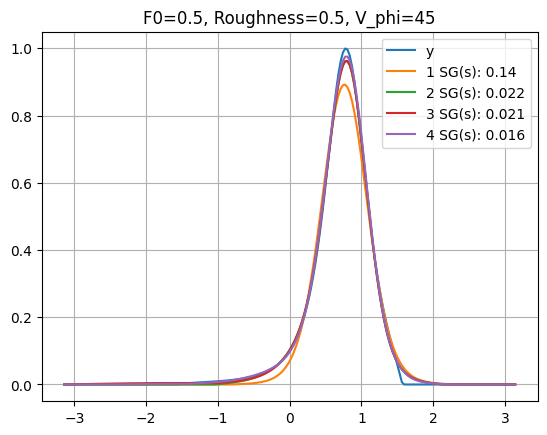

Initial parameters:
[[0.52359878 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.57418234  4.26880924  5.75623442 16.29970179]]
Loss: 4.24279092169956 (infx better)

Initial parameters:
[[ 0.57418234  4.26880924  5.75623442 16.29970179]
 [ 0.07728183  0.          0.          0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.49393341  3.95847254  9.50010883 28.21830993]
 [ 0.84349196  1.19072628  4.00702523  4.34466549]]
Loss: 0.9664394934920117 (4.390125766041689x better)

Initial parameters:
[[4.93933412e-01 3.95847254e+00 9.50010883e+00 2.82183099e+01]
 [8.43491961e-01 1.19072628e+00 4.00702523e+00 4.34466549e+00]
 [2.25001445e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Opt

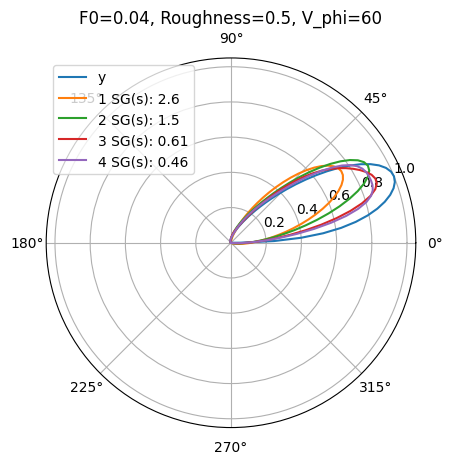

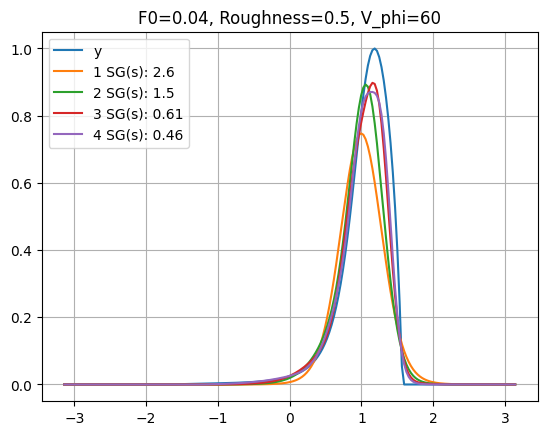

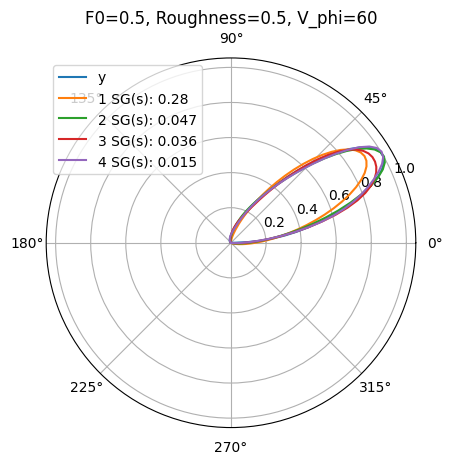

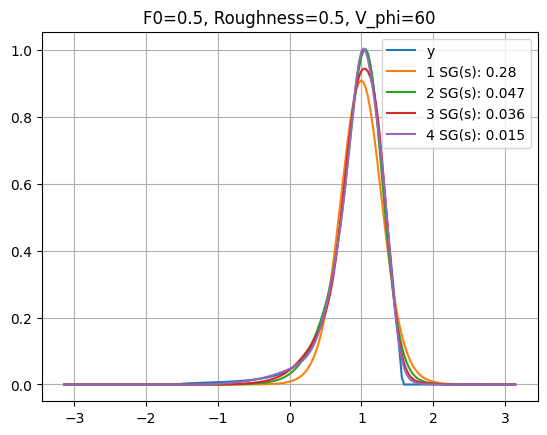

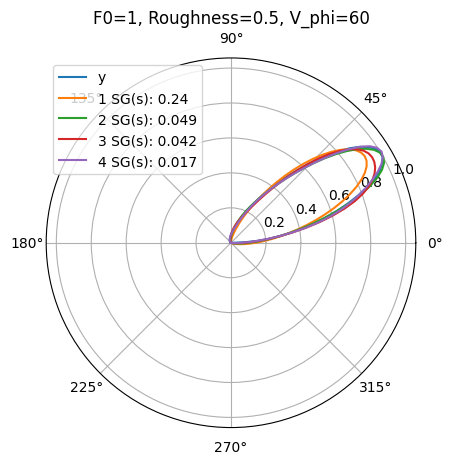

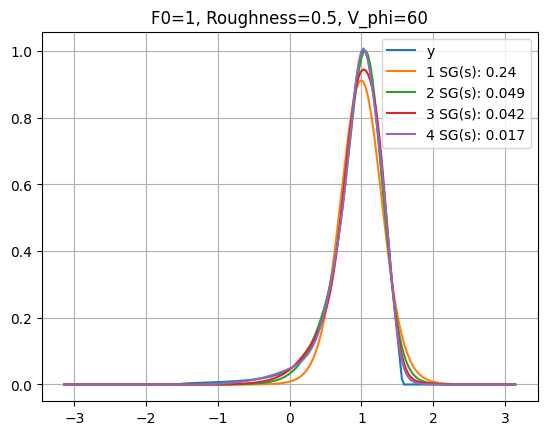

Initial parameters:
[[0.26179939 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.38793774  3.44812785  8.89560483 45.16843274]]
Loss: 4.828921813814745 (infx better)

Initial parameters:
[[3.87937744e-01 3.44812785e+00 8.89560483e+00 4.51684327e+01]
 [2.25001445e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[  0.28653638   3.37254355  20.53466677 100.44699536]
 [  0.61244828   1.39088932   7.06954911  12.25456663]]
Loss: 1.282312133753336 (3.7657928102734695x better)

Initial parameters:
[[  0.28653638   3.37254355  20.53466677 100.44699536]
 [  0.61244828   1.39088932   7.06954911  12.25456663]
 [  6.26934461   0.           0.           0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfu

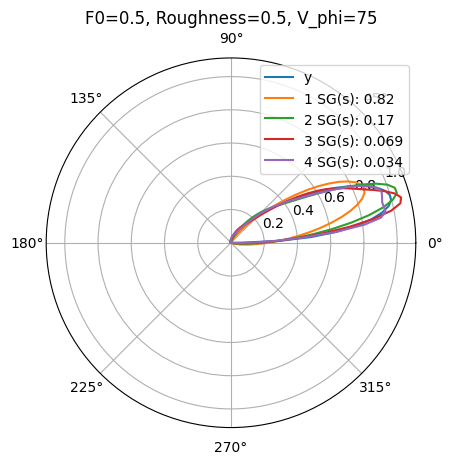

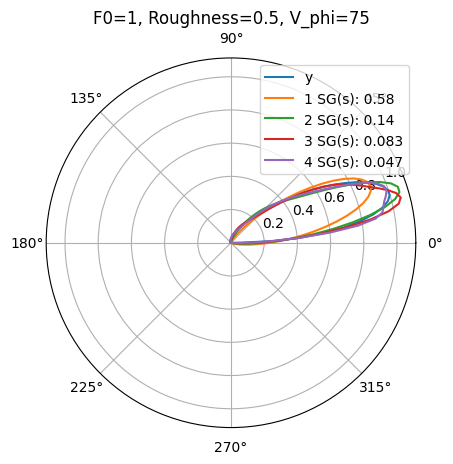

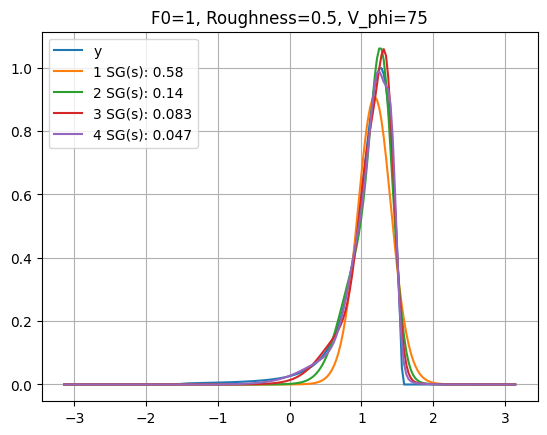

Initial parameters:
[[0.01745329 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[  0.29042508   0.39475222  14.06417095 177.27267939]]
Loss: 3.450604019309179 (infx better)

Initial parameters:
[[  0.29042508   0.39475222  14.06417095 177.27267939]
 [  6.26934461   0.           0.           0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[2.01356710e-01 4.97395617e-01 4.43537826e+01 5.76598761e+02]
 [4.89801419e-01 1.67620307e-01 1.01599071e+01 3.14675419e+01]]
Loss: 1.014634899712746 (3.4008331669707816x better)

Initial parameters:
[[2.01356710e-01 4.97395617e-01 4.43537826e+01 5.76598761e+02]
 [4.89801419e-01 1.67620307e-01 1.01599071e+01 3.14675419e+01]
 [6.26934461e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping it

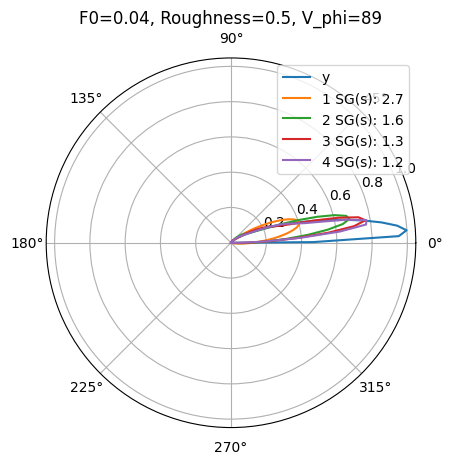

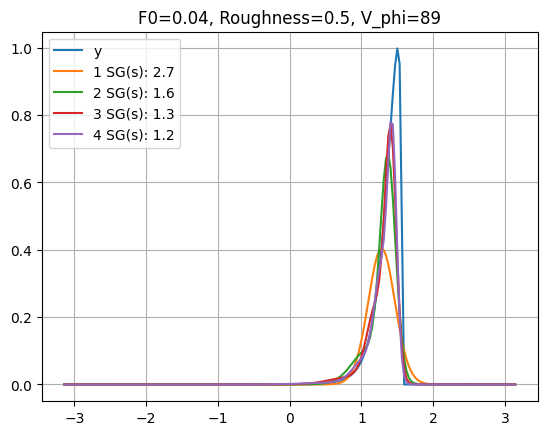

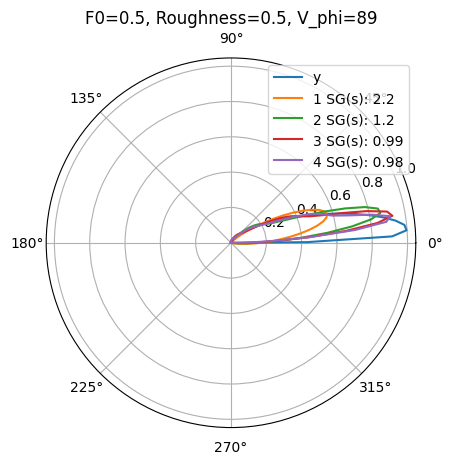

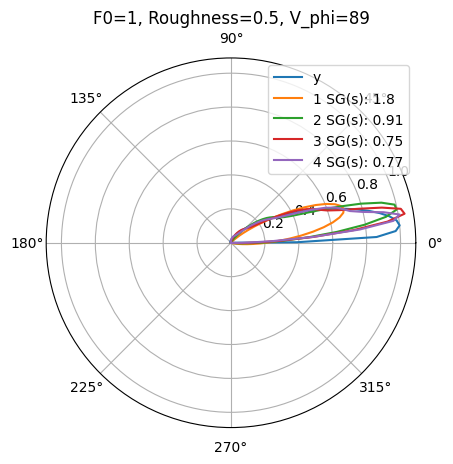

Initial parameters:
[[1.55334303 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.55440716 2.27025009 1.90244035 1.90340071]]
Loss: 1.700373713898352 (infx better)

Initial parameters:
[[1.55440716 2.27025009 1.90244035 1.90340071]
 [1.35055191 0.         0.         0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.55257385 1.96057604 3.30647267 3.30741293]
 [1.56386161 0.47614236 0.         0.        ]]
Loss: 0.026544018701733216 (64.05863908569822x better)

Initial parameters:
[[1.55257385 1.96057604 3.30647267 3.30741293]
 [1.56386161 0.47614236 0.         0.        ]
 [1.35055191 0.         0.         0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.55388295e+00 1.85556719e+00 3.45707494e+00 3

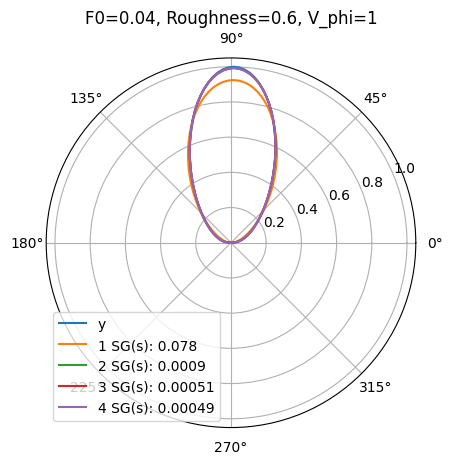

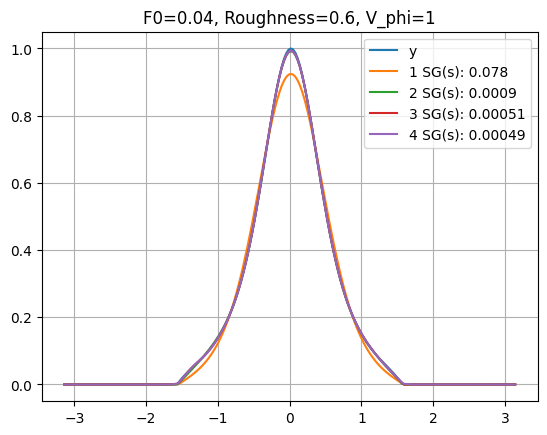

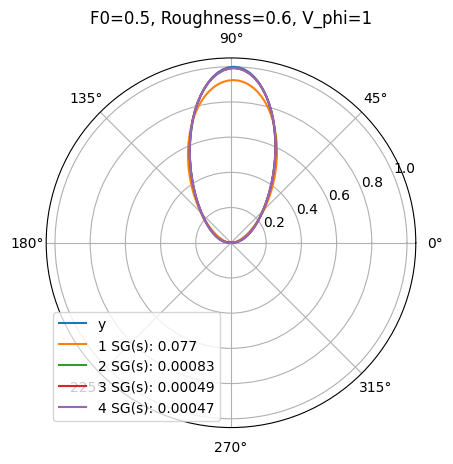

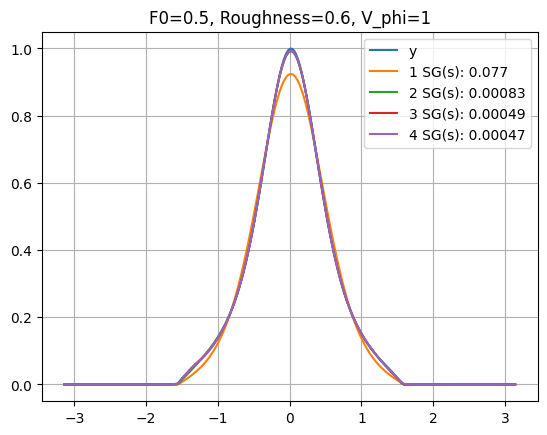

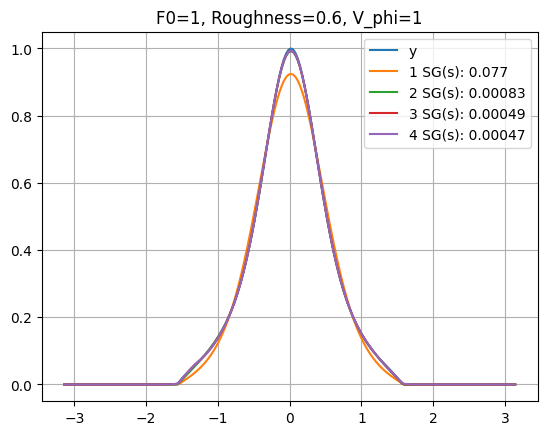

Initial parameters:
[[1.30899694 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.32469689 2.26857787 1.96927708 2.07310325]]
Loss: 2.317022508263981 (infx better)

Initial parameters:
[[1.32469689 2.26857787 1.96927708 2.07310325]
 [0.0643531  0.         0.         0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.29949632 2.01829947 3.05466076 3.25527345]
 [1.49546646 0.39431848 0.         0.        ]]
Loss: 0.2339277883584892 (9.90486219924071x better)

Initial parameters:
[[1.29949632 2.01829947 3.05466076 3.25527345]
 [1.49546646 0.39431848 0.         0.        ]
 [0.00895    0.         0.         0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.30428955 2.04611199 3.21610509 3.30084021]
 [1.

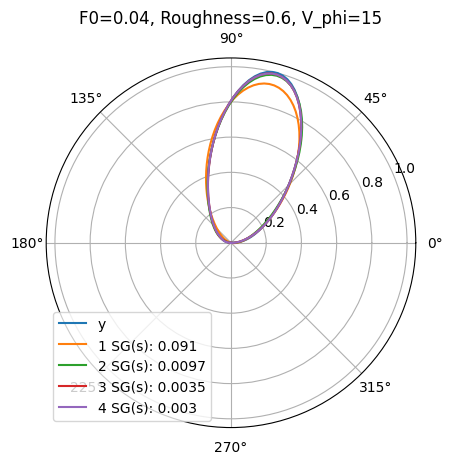

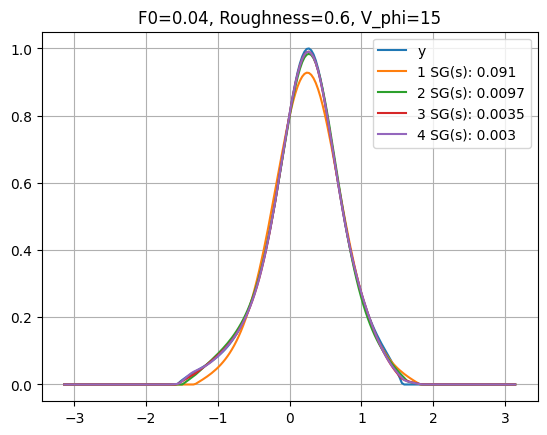

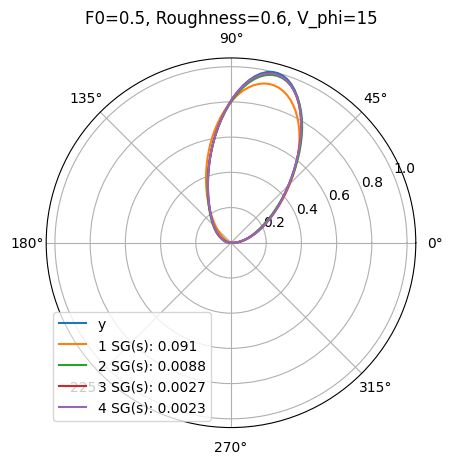

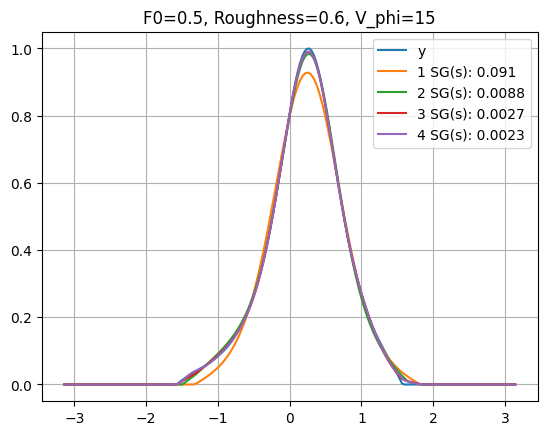

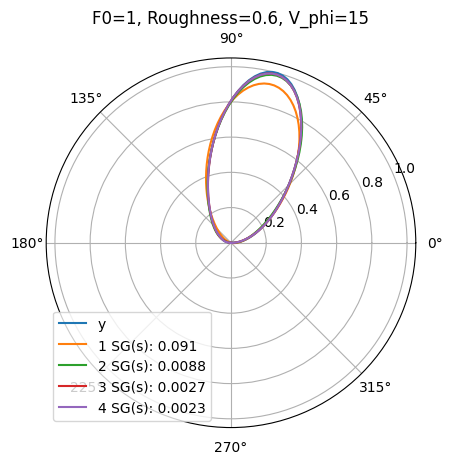

Initial parameters:
[[1.04719755 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.08731871 2.24627045 2.16833019 2.63132378]]
Loss: 4.327643347648913 (infx better)

Initial parameters:
[[1.08731871 2.24627045 2.16833019 2.63132378]
 [6.26379221 0.         0.         0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[1.03689406 2.09714021 2.96129886 3.74015369]
 [1.51300988 0.31233126 0.2391861  0.        ]]
Loss: 0.5306726072793625 (8.155015518580758x better)

Initial parameters:
[[1.03689406 2.09714021 2.96129886 3.74015369]
 [1.51300988 0.31233126 0.2391861  0.        ]
 [0.30200125 0.         0.         0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[0.98882646 0.72279157 3.18790594 7.05858654]
 [1

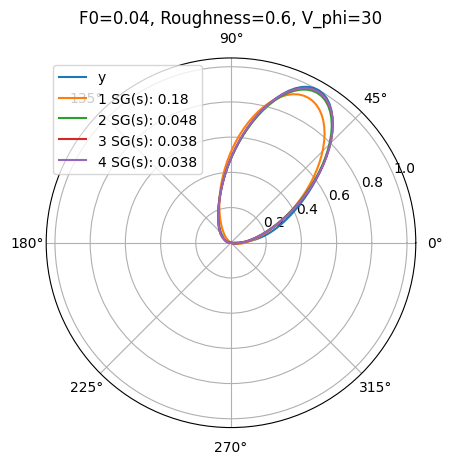

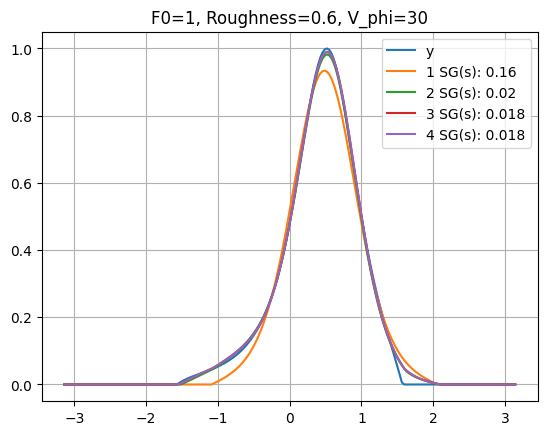

Initial parameters:
[[0.78539816 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[0.86625533 2.16104418 2.51856057 3.80584573]]
Loss: 8.189584349554753 (infx better)

Initial parameters:
[[0.86625533 2.16104418 2.51856057 3.80584573]
 [0.30200125 0.         0.         0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[0.77587497 2.07935659 3.8760639  5.72147036]
 [1.37776703 0.4313087  1.21978814 0.54359289]]
Loss: 1.6994343286659335 (4.819006072440367x better)

Initial parameters:
[[0.77587497 2.07935659 3.8760639  5.72147036]
 [1.37776703 0.4313087  1.21978814 0.54359289]
 [0.30200125 0.         0.         0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[0.47318669 0.8046727  9.92990719 7.23189221]
 [0

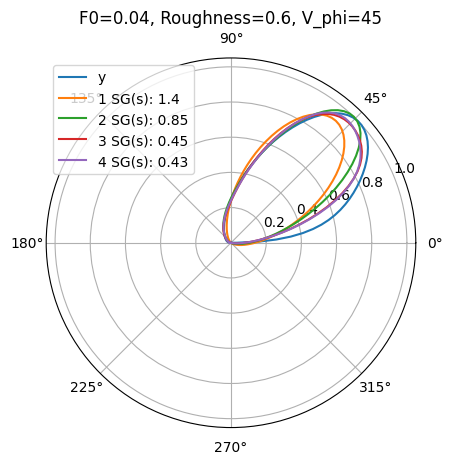

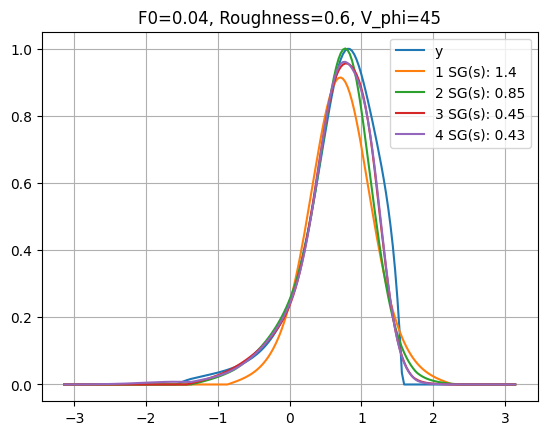

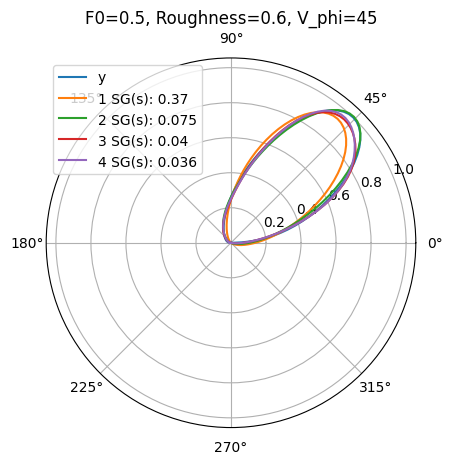

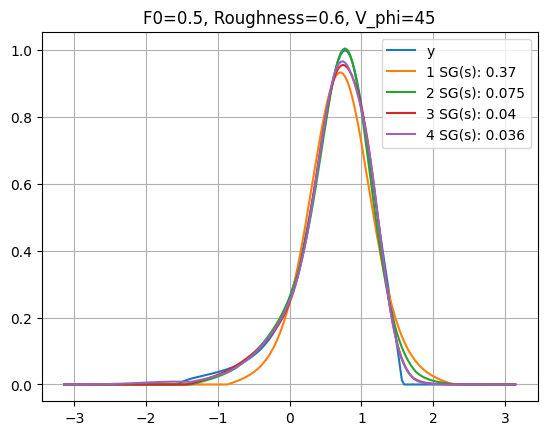

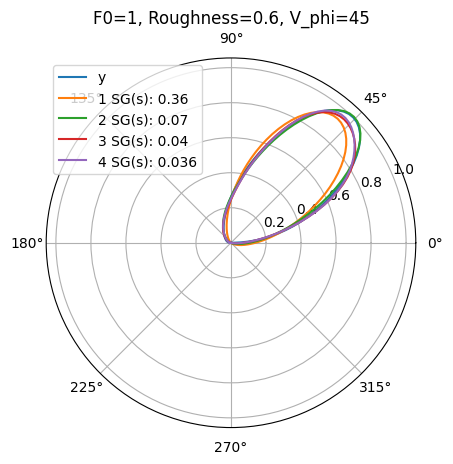

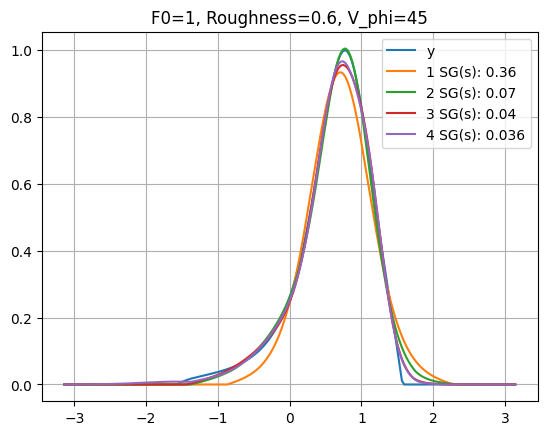

Initial parameters:
[[0.52359878 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[0.66885926 1.93718202 3.15484474 6.46737952]]
Loss: 13.602950226623001 (infx better)

Initial parameters:
[[0.66885926 1.93718202 3.15484474 6.46737952]
 [0.07728183 0.         0.         0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.52011778  1.83400753  6.90702823 12.87488396]
 [ 1.04054845  0.71305468  2.43213138  1.959609  ]]
Loss: 3.4418942900481238 (3.952169671786407x better)

Initial parameters:
[[ 0.52011778  1.83400753  6.90702823 12.87488396]
 [ 1.04054845  0.71305468  2.43213138  1.959609  ]
 [ 0.02250014  0.          0.          0.        ]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.52011778  1.83400753  6.

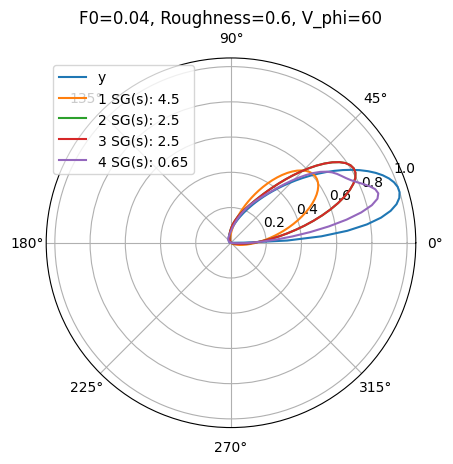

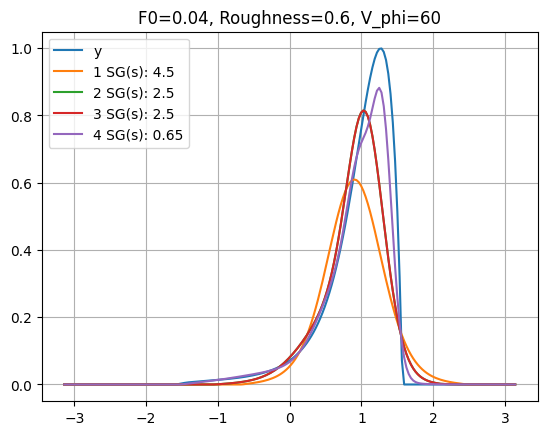

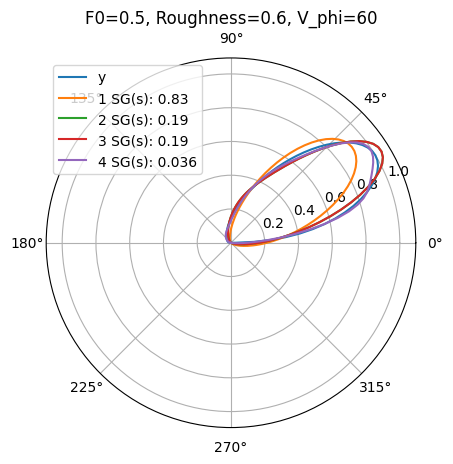

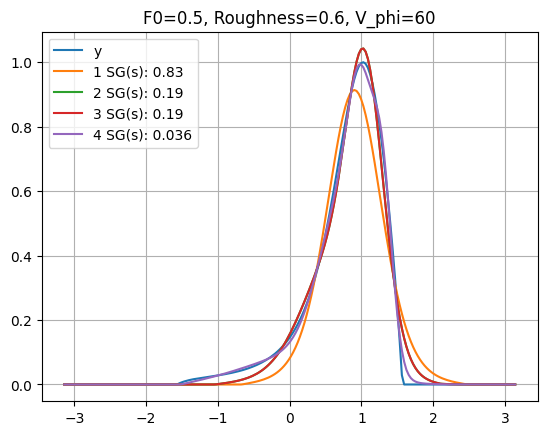

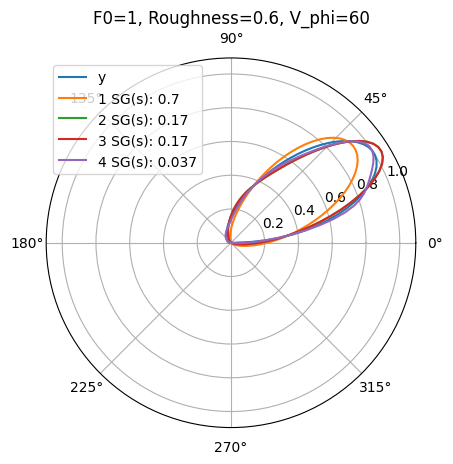

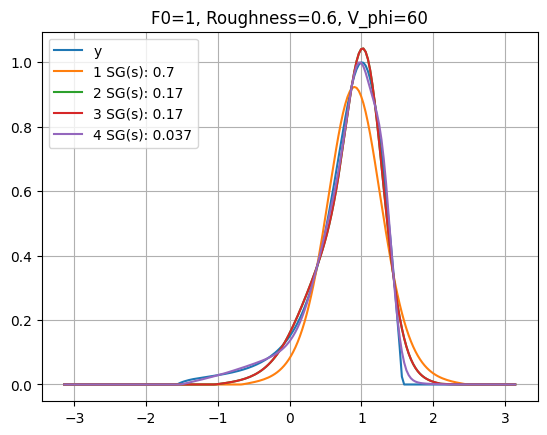

Initial parameters:
[[0.26179939 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.51702873  1.36541169  4.25559487 13.42593892]]
Loss: 14.508937653642722 (infx better)

Initial parameters:
[[ 0.51702873  1.36541169  4.25559487 13.42593892]
 [ 0.02250014  0.          0.          0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.85682073  0.55876711  3.10845708  3.32591736]
 [ 0.36713892  1.41169716 11.4873706  34.04154477]]
Loss: 3.915145143436848 (3.705849239833362x better)

Initial parameters:
[[8.56820731e-01 5.58767111e-01 3.10845708e+00 3.32591736e+00]
 [3.67138918e-01 1.41169716e+00 1.14873706e+01 3.40415448e+01]
 [2.25001445e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Op

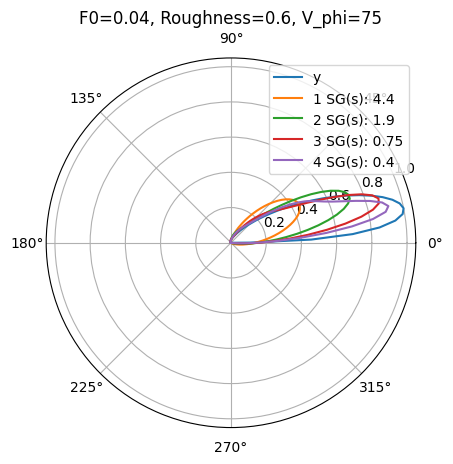

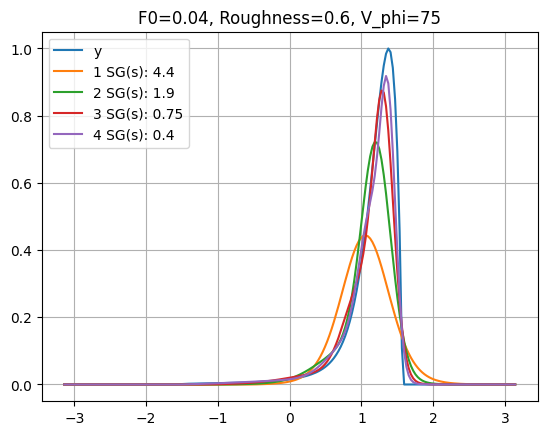

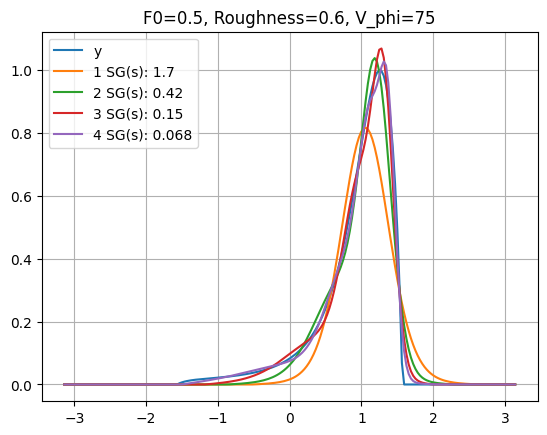

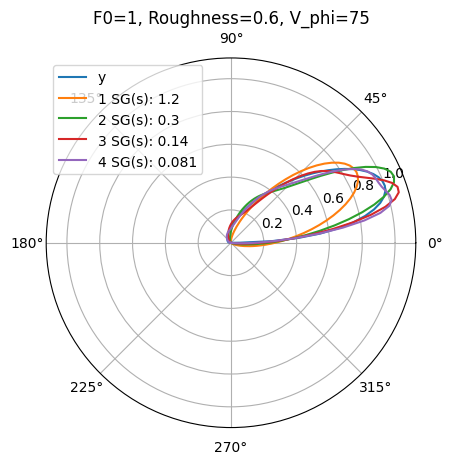

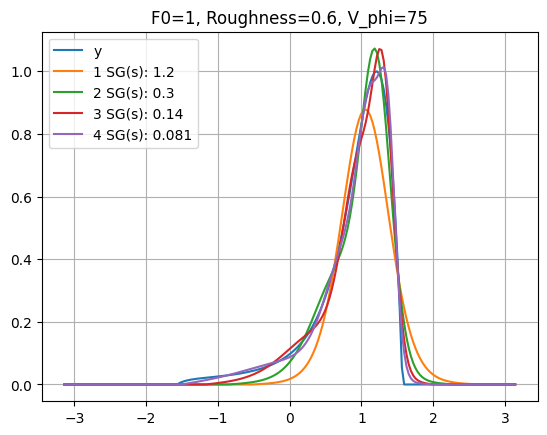

Initial parameters:
[[0.01745329 0.         0.         0.        ]]
Fit 1 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[ 0.42046239  0.13811755  5.92779606 36.11305222]]
Loss: 10.141150681145422 (infx better)

Initial parameters:
[[ 0.42046239  0.13811755  5.92779606 36.11305222]
 [ 6.26934461  0.          0.          0.        ]]
Fit 2 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations completed successfully']
Optimal parameters:
[[2.64837871e-01 1.71757283e-01 2.00343979e+01 1.57970074e+02]
 [7.09102638e-01 6.08404101e-02 3.77777993e+00 6.28672976e+00]]
Loss: 3.5935396159478996 (2.822050614424742x better)

Initial parameters:
[[2.64837871e-01 1.71757283e-01 2.00343979e+01 1.57970074e+02]
 [7.09102638e-01 6.08404101e-02 3.77777993e+00 6.28672976e+00]
 [6.26934461e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Fit 3 SG(s) in 10 iteration(s): ['requested number of basinhopping iterations co

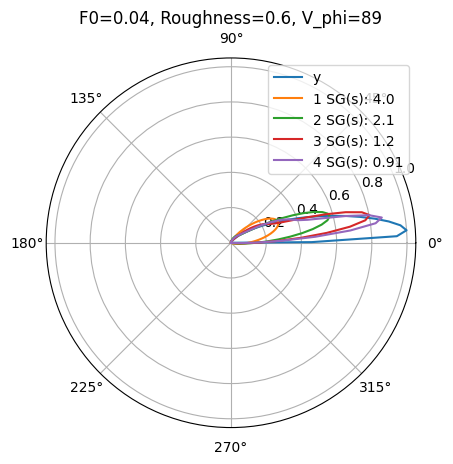

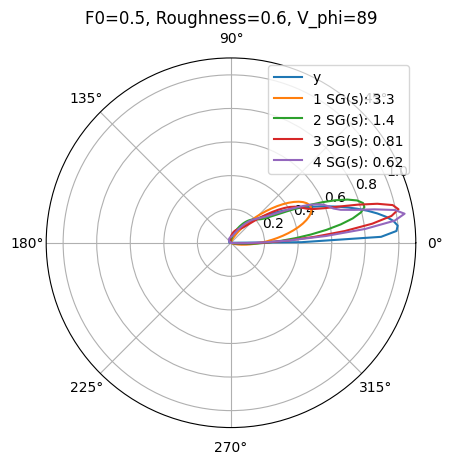

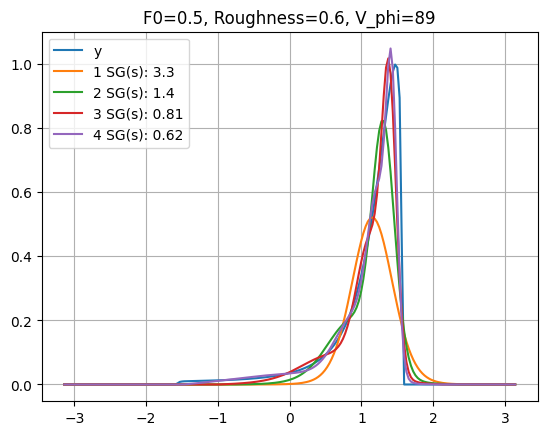

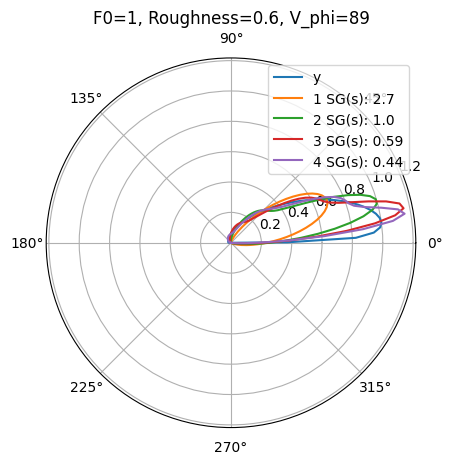

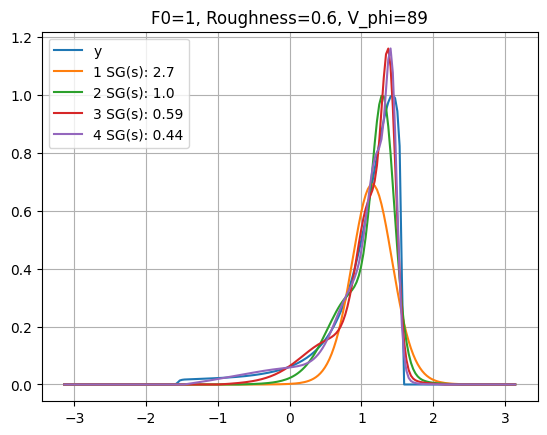

In [10]:
# Fit F * G * D ASG

for roughness in (0.4, 0.5, 0.6):
    for V_phi in (1, 15, 30, 45, 60, 75, 89):
        alpha = roughness ** 2
    
        N = polar_to_r3(np.pi / 2)
        V = polar_to_r3(np.pi / 2 + np.radians(V_phi))
        R_phi = np.pi / 2 - np.radians(V_phi)

        phi = np.linspace(-1/2*np.pi, 3/2*np.pi, num=10000)
        L = polar_to_r3(phi)
        H = normalize(L + V)

        norm = np.empty(101)
        for i in range(len(norm)):
            f0 = i / (len(norm) - 1)
            y = F_schlick(f0, dot(H, V)) * D_ggx(alpha, dot(N, H)) * G_smith(alpha, dot(N, V), dot(N, L)) * np.heaviside(dot(N, L), 0)
            norm[i] = 1 / np.max(y)
        def F_norm(f0, NoV):
            i = np.round(f0 * (len(norm) - 1)).astype(np.int64)
            return F_schlick(f0, NoV) * norm[i]
 
        Xi = r3_seq(np.arange(10_000))
        f0 = 0.02 + 0.98 * Xi[0]
        phi, theta = uniform_sample_sphere(Xi[1:])
        L = spherical_to_r3(phi, theta)
        X = np.concatenate((f0.reshape(1, -1), L))
        H = normalize(L + V)
        y = F_norm(f0, dot(H, V)) * D_ggx(alpha, dot(N, H)) * G_smith(alpha, dot(N, V), dot(N, L)) * np.heaviside(dot(N, L), 0)

        NUM_PARAMS = 4
      
        def f(X, params):
            params = params.reshape(-1, NUM_PARAMS, 1)
            y = normalize(cross(N, V)).reshape(1, 3, 1)
            z = polar_to_r3(params[:, 0], axis=1)
            x = cross(y, z)
            v = V.reshape(1, 3, 1)
            a = params[:, 1] * F_norm(X[0], dot(normalize(z + v), v))
            l = params[:, 2]
            u = params[:, 3]
            return ASG(x, y, z, a, l, u).eval(X[1:])
    
        asgs = []
    
        def fit(p0):
            k = len(p0) // NUM_PARAMS
            lo = np.tile((-np.pi,  0     , 0     , 0     ), k)
            hi = np.tile(( np.pi,  np.inf, np.inf, np.inf), k)
            return fit_f(f, X, y, p0, lo, hi, ni=10)
    
        popt = None
        l = np.inf
        for k in range(1, 4 + 1):
            if popt is None:
                popt = np.array([R_phi, 0, 0, 0])
            else:
                i = np.argmax(np.abs(y - f(X, popt)))
                popt = np.append(popt, [phi[i], 0, 0, 0])
            print(f"Initial parameters:\n{popt.reshape(-1, NUM_PARAMS)}")
            res = fit(popt)
            popt = res.x
            print(f"Fit {k} SG(s) in {res.nit} iteration(s): {res.message}")
            print(f"Optimal parameters:\n{popt.reshape(-1, NUM_PARAMS)}")
            print(f"Loss: {res.fun} ({l / res.fun}x better)\n")
            assert(l / res.fun >= 0.99)
            l = res.fun
            asgs.append(popt)

        for f0 in (0.04, 0.5, 1):
            phi = np.linspace(-1/2*np.pi, 3/2*np.pi, num=200)
            f0 = np.full(phi.shape, f0)
            L = polar_to_r3(phi)
            X = np.concatenate((f0.reshape(1, -1), L))
            H = normalize(L + V)
            y = F_norm(f0, dot(H, V)) * D_ggx(alpha, dot(N, H)) * G_smith(alpha, dot(N, V), dot(N, L)) * np.heaviside(dot(N, L), 0)
        
            fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
            plt.title(f"F0={f0[0]}, Roughness={roughness}, V_phi={V_phi}")
            ax.plot(phi, y, label="y")
            for asg in asgs:
                k = len(asg) // NUM_PARAMS
                p = f(X, asg)
                ax.plot(phi, p, label=f"{k} SG(s): {loss(p, y):.2}")
            ax.legend()
            ax.grid(True)
            plt.show()
        
            fig, ax = plt.subplots()
            plt.title(f"F0={f0[0]}, Roughness={roughness}, V_phi={V_phi}")
            ax.plot(np.pi / 2 - phi, y, label="y")
            for asg in asgs:
                k = len(asg) // NUM_PARAMS
                p = f(X, asg)
                ax.plot(np.pi / 2 - phi, p, label=f"{k} SG(s): {loss(p, y):.2}")
            ax.grid(True)
            ax.legend()
            plt.show()